In [1]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import hpp_checker as hpp

import pyteomics.auxiliary as aux
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
project_palette={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue"}
proteins_palette={"Canonical":"orangered","Non-canonical":"cornflowerblue","Reference isoforms":"yellowgreen","Novel isoforms":"gold"}
project_palette2={"canon":"orangered","trembl":"yellowgreen","openprot":"cornflowerblue",
                "Canon_unique":"salmon", "NonCanon_unique":"skyblue", "Shared":"darkkhaki",
                "Canon":"firebrick","Noncanon":"steelblue","TPP_canon":"lightcoral","TPP_trembl":"greenyellow","TPP_openprot":"paleturquoise",
                  "ionbot_canon":"orangered","ionbot_trembl":"yellowgreen","ionbot_openprot":"cornflowerblue",
                 "TPP_canon_unique":"chocolate",
                  "TPP_canon_unique_shared_in_class":"saddlebrown",
                  "TPP_noncanon_unique":"plum",
                  "TPP_noncanon_unique_shared_in_class":"orchid",
                  "TPP_shared":"tan",
                  "ionbot_canon_unique":"salmon",
                  "ionbot_canon_unique_shared_in_class":"rosybrown",
                  "ionbot_noncanon_unique":"skyblue",
                  "ionbot_noncanon_unique_shared_in_class":"mediumturquoise",
                  "ionbot_shared":"darkkhaki",
                 "ionbot_canon_unique_OnlyMod":"firebrick",
                 "ionbot_canon_unique_OnlyUnmod":"indianred",
                 "ionbot_canon_unique_Both":"lightcoral",
                 "ionbot_noncanon_unique_OnlyMod":"royalblue",
                 "ionbot_noncanon_unique_OnlyUnmod":"dodgerblue",
                 "ionbot_noncanon_unique_Both":"lightblue",
                 "ionbot_shared_OnlyMod":"olivedrab",
                 "ionbot_shared_OnlyUnmod":"olive",
                 "ionbot_shared_Both":"darkseagreen",}

In [3]:
peptide_classes={"NonCanon_unique":["unique_to_Noncanon",'shared_in_Noncanon'],
                "Canon_unique":["unique_to_Canon",'shared_in_Canon'],
                "Shared":['shared_btw_can_noncan']}

In [4]:
global_folder="./../"
working_folder = "./../fromUGhent_v0114_3/"
figsave_folder="./oui_discovery_gwalk_subfigures/explore-1-hybrid-ionbot-open/"
wildcard="io_open"

In [5]:
#list my directory tree
dt.list_files(working_folder)

/
    Comparison-0-group-wise-protgroups-20250417-closed.svg
    Comparison-0-group-wise-protgroups-20250417.svg
    2025-04-18-ionbot-results.zip
    ID-rates-2.svg
    FDR-levels.svg
    ID-rates-1.svg
    PSM-counts.svg
PXD014258-closed/
    Metadata_PXD014258-closed-trembl.txt
    Metadata_PXD014258-closed-canon.txt
    Metadata_PXD014258-closed-open.txt
    PXD014258-closed-openprot/
        PXD014258-closed-openprot-combined-results.csv
        target-decoy-plot.png
        group-walk-output.csv
        Sample-BT474-closed-open/
            subgroups_Occam.tsv
            sample_protein_groups_Occam.csv
            ionbot.first.proteins.csv
            ionbot.first.csv
            ionbot.meta.csv
            groups_Occam.tsv
            ionbot.features.csv
            ionbot.first.peptides.csv
            ionbot.stats.csv
            sample-protein-inference-input.pout
            ionbot.modifications.csv
        Sample-MCF-closed-open/
            ionbot.first.proteins.csv
     

In [6]:
mgfspectraN_datasets=pickle.load(open(f'{global_folder}mgfspectraN_datasets.pickle', 'rb'))

In [7]:
OPfasta_file=f'{global_folder}ionbot_openprot/openprot_2_0_0-human-ensembl106+refseq+uniprot2022_06_01.fasta'
input_file = open(OPfasta_file)
OPfasta = SeqIO.to_dict(SeqIO.parse(OPfasta_file, "fasta"))

In [8]:
def classify_leadprot(x):
    if 'CONTAMINANT' in x.upper():
        return 'Contam'
    elif x.startswith('II_') or x.startswith('IP_'):
        return 'NonCanon'
        # Ensembl is canonical
    else:
        return 'Canon'

def is_peptide_canonical(x):
    '''x is the list of protein classes'''
    if np.array([_=='Contam' for _ in x]).any():
        return 'Contam'
    if np.array([_=='Canon' for _ in x]).any():
        return 'Canonical'
    return 'NonCanonical'

def classifiy_mods(row):
    if row.modifications=='Unmodified':
        return 'Unmodified'
    elif len(row.unexpected_modification)>1:
        return 'Unexpected'
    else:
        return 'Expected'

def custom_subgroup_filter(data_):
    filtered_subgroups = []
    for (c,m),df in data_.groupby(['isCanonical','isModified']).__iter__():
        tmp = aux.target_decoy.qvalues(df, key='psm_score', reverse=True, is_decoy=df.database=='D',
                                      formula=1, full_output=True, q_label='custom_q')
        filtered_subgroups.append(tmp)

    return pd.concat(filtered_subgroups, ignore_index=True)

### Load group walk

In [ ]:
def load_combined_gwalk(working_folder,dataset_name,sufix="group-walk-output.csv"):
    
    combined_first=pd.DataFrame()
    #set path
    canonical_path = os.path.join(working_folder, dataset_name, f'{dataset_name}-canon', 
                              sufix)
    trembl_path    = os.path.join(working_folder, dataset_name, f'{dataset_name}-trembl', 
                                  sufix)
    openprot_path  = os.path.join(working_folder, dataset_name, f'{dataset_name}-openprot', 
                                  sufix)
    #load
    patt = re.compile(r'.+?.+?') #for removing retention time in parentasies
    for path,db in zip([canonical_path,trembl_path,openprot_path],{"canon","trembl","openprot"}):
        df=pd.read_csv(path)
        #df['spectrum_file'] = df.experiment.apply(lambda x: x.replace(f"-{db}","")+'.mgf')
        df['modified_peptide'] = df.matched_peptide + '|' + df.modifications
        df['modifications_noRT'] = df.modifications.str.replace(patt, '', regex=True)
        df["searchDB"]=db
        df["dataset_name"]=dataset_name
        combined_first=pd.concat([combined_first,df])
    return combined_first

In [ ]:
groupwalk_output=pd.DataFrame()
sufix="group-walk-output.csv"
for dataset_name in {"PXD002057.v0.11.4","PXD005833.v0.11.4","PXD014258.v0.11.4"}:
    df=load_combined_gwalk(working_folder,dataset_name,sufix)
    groupwalk_output=pd.concat([groupwalk_output,df])

In [ ]:
groupwalk_output[['experiment','searchDB',
       'dataset_name']].value_counts()

In [ ]:
groupwalk_output.columns

### Load PSM level

In [9]:
combined_first_datasets={"PXD002057.v0.11.4":0,"PXD005833.v0.11.4":0,"PXD014258.v0.11.4":0}
sufix="-combined-results.csv"
combined_first_datasets["PXD002057.v0.11.4"]=io.load_combined_first(working_folder,"PXD002057.v0.11.4",sufix)
combined_first_datasets["PXD005833.v0.11.4"]=io.load_combined_first(working_folder,"PXD005833.v0.11.4",sufix)
combined_first_datasets["PXD014258.v0.11.4"]=io.load_combined_first(working_folder,"PXD014258.v0.11.4",sufix)

### Global, cutom and hybrid FDR

In [10]:
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df_ds=combined_first_datasets[dataset_name][database]
        df_ds_new=[]
        for spectrum_file in set(df_ds.spectrum_file):
            data=df_ds.loc[df_ds.spectrum_file==spectrum_file]
            data = aux.target_decoy.qvalues(data, key='psm_score', reverse=True, is_decoy=data.database=='D',
                                    q_label='global_q',
                                    formula=1, full_output=True)
            data.sort_values('database', ascending=False, inplace=True)
            data.unexpected_modification = data.unexpected_modification.fillna('')
            #process proteins names
            data["proteins_list"] = data.proteins.str.split('||', regex=False)
            # if peptide maps to >100 proteins, only consider the first 100
            data.proteins_list = data.proteins_list.apply(lambda x: x[:100] if len(x)>100 else x)
            # protein format = 'P60981-2((116-129))((P60981-2))' --> split on the parenthesis, take 4th element
            data.proteins_list = data.proteins_list.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            
            data['protein_classes'] = data.proteins_list.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #add hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            #indicate best PSM per peptide
            psm_score_best=data2.groupby("database_peptide")["psm_score"].apply(lambda x: x.max())
            data2["psm_score_isBest"]=data2.apply(lambda x: x["psm_score"]==psm_score_best[x["database_peptide"]], axis=1)
            #indicate modification type per peptide
            mod_type=data2.groupby("database_peptide")["isModified"].apply(lambda x: "Unexpected" if "Unexpected" in set(x) 
                                                                          else "Expected" if "Expected" in set(x)
                                                                          else "Unmodified")
            data2["database_peptide_isModified"]=data2.apply(lambda x: mod_type[x["database_peptide"]], axis=1)
            
            df_ds_new.append(data2)
        combined_first_datasets[dataset_name][database]=pd.concat(df_ds_new)

/home/vvshazia/miniconda3/envs/general/lib/python3.13/site-packages/pyteomics/auxiliary/target_decoy.py:83: RuntimeWarning: divide by zero encountered in divide
  q = tfalse / (ind - cumsum) / ratio


In [11]:
with open('combined_first_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_first_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Compare global and cosum output

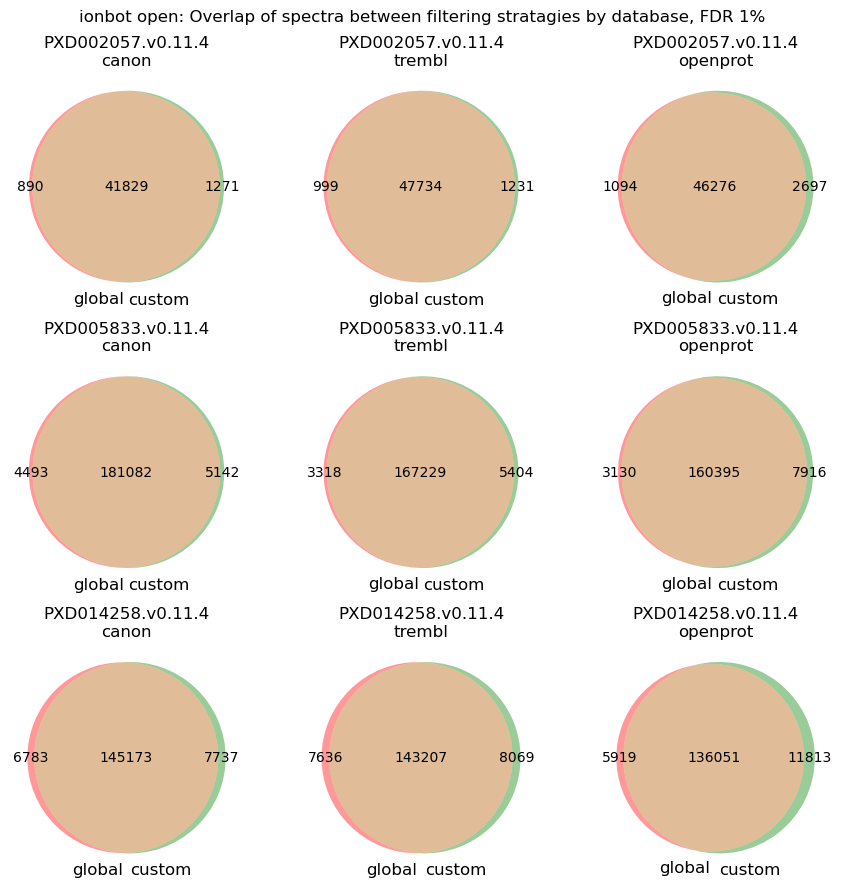

In [12]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("ionbot open: Overlap of spectra between filtering stratagies by database, FDR 1%")

for i,(dataset, subdict) in enumerate(combined_first_datasets.items()):
    for j,(database,data) in enumerate(subdict.items()):
        glob=data[data['global_q']<0.01].spectrum_title
        cust=data[data['custom_q']<0.01].spectrum_title
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title(f"{dataset}\n{database}")
plt.tight_layout()

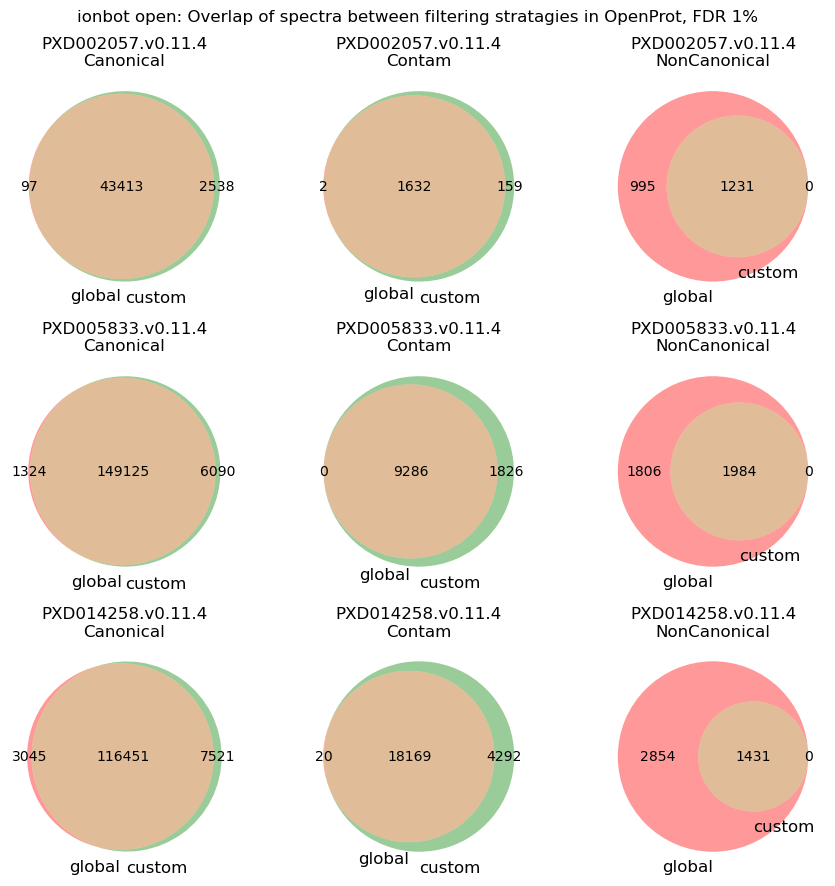

In [13]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("ionbot open: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(combined_first_datasets.items()):
    data=subdict["openprot"]
    for j,(isCanonical,group) in enumerate(data.groupby("isCanonical")):
        glob=group[group['global_q']<0.01].spectrum_title
        cust=group[group['custom_q']<0.01].spectrum_title
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title(f"{dataset}\n{isCanonical}")
plt.tight_layout()

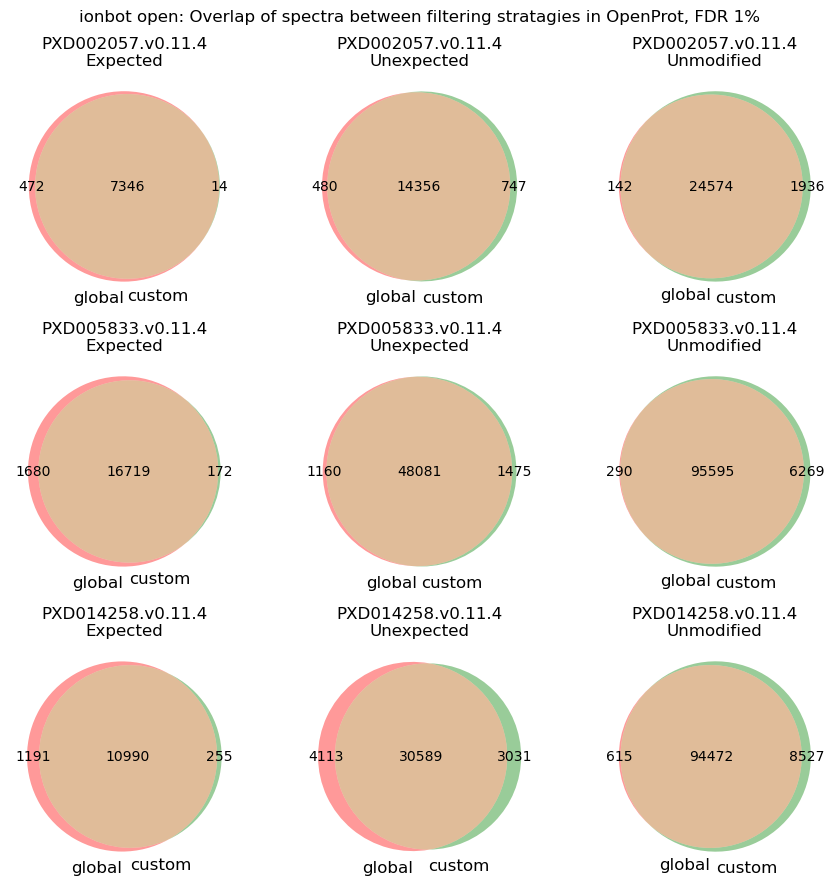

In [14]:
fig, axes = plt.subplots(3,3, figsize=(9, 9))
fig.suptitle("ionbot open: Overlap of spectra between filtering stratagies in OpenProt, FDR 1%")

for i,(dataset, subdict) in enumerate(combined_first_datasets.items()):
    data=subdict["openprot"]
    for j,(isModified,group) in enumerate(data.groupby("isModified")):
        glob=group[group['global_q']<0.01].spectrum_title
        cust=group[group['custom_q']<0.01].spectrum_title
        venn2((set(glob), set(cust)), set_labels=('global', 'custom'), ax=axes[i,j])
        axes[i,j].set_title(f"{dataset}\n{isModified}")
plt.tight_layout()

#### Compare custom q-value and group-walk-output files

In [ ]:
comb_firstgw=pd.DataFrame()
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        df_gwl=groupwalk_output[(groupwalk_output.dataset_name==dataset_name)&(groupwalk_output.searchDB==database)]
        print(dataset_name,database,len(df)==len(df_gwl),len(df),len(df_gwl))
        comb=df.merge(df_gwl[['ionbot_match_id', 'spectrum_title', 'scan','q.value','custom_q','group_qval']],on=['ionbot_match_id', 'spectrum_title', 'scan'],
                      how="outer", suffixes=("_first","_gwalk"))
        comb["dataset_name"]=dataset_name
        comb["searchDB"]=database
        comb_firstgw=pd.concat([comb_firstgw,comb])

In [ ]:
#a[["q-value","global_q","q.value","custom_q_first","custom_q_gwalk"]]

In [ ]:
a=comb_firstgw[(comb_firstgw.dataset_name=="PXD002057.v0.11.4")&(comb_firstgw.searchDB=="canon")]#[["q-value","custom_q_x","custom_q_y"]]
(a.custom_q_first==a.custom_q_gwalk).value_counts()

In [ ]:
#global from first and recalculated by pytheomics
a=comb_firstgw[(comb_firstgw.dataset_name=="PXD002057.v0.11.4")&(comb_firstgw.searchDB=="canon")]#[["q-value","custom_q_x","custom_q_y"]]
(a["q-value"]==a.global_q).value_counts()

In [ ]:
#plt.hist((comb_firstgw["q-value"]-comb_firstgw.global_q));

In [ ]:
for (dataset_name,isCanonical),data in comb_firstgw[comb_firstgw.searchDB=="openprot"].groupby(["dataset_name","isCanonical"]):
    print((dataset_name,isCanonical))
    glob=data[(data['global_q']<0.01)&(data.global_q.isna()==False)].spectrum_title
    cust=data[(data['custom_q_first']<0.01)&(data.global_q.isna()==False)].spectrum_title
    venn2((set(glob), set(cust)), set_labels=('global', 'custom'))
    plt.title((dataset_name,isCanonical))
    plt.show()

### Load peptide level, calculate global and custom FDR, filter decoy and contominant

In [15]:
fix_spectrum_file={"PXD002057.v0.11.4":{
                    "canon":{'130327_o2_06_hu_P3_2hr.mgf.gzip':'130327_o2_06_hu_P3_2hr.mgf',
                            '130327_o2_02_hu_P1_2hr.mgf.gzip':'130327_o2_02_hu_P1_2hr.mgf',
                              '130327_o2_03_hu_C2_2hr.mgf.gzip':'130327_o2_03_hu_C2_2hr.mgf',
                               '130327_o2_05_hu_C3_2hr.mgf.gzip':'130327_o2_05_hu_C3_2hr.mgf',
                              '130327_o2_01_hu_C1_2hr.mgf.gzip':'130327_o2_01_hu_C1_2hr.mgf',
                              '130327_o2_04_hu_P2_2hr.mgf.gzip':'130327_o2_04_hu_P2_2hr.mgf'},
                   "trembl":{'130327_o2_06_trembl':'130327_o2_06_hu_P3_2hr.mgf', 
                            '130327_o2_05_trembl':'130327_o2_05_hu_C3_2hr.mgf', 
                            '130327_o2_03_trembl':'130327_o2_03_hu_C2_2hr.mgf', 
                            '130327_o2_01_trembl':'130327_o2_01_hu_C1_2hr.mgf', 
                            '130327_o2_02_trembl':'130327_o2_02_hu_P1_2hr.mgf', 
                            '130327_o2_04_trembl':'130327_o2_04_hu_P2_2hr.mgf'},
                   "openprot":{'130327_o2_03_hu_C2_2hr-openprot':'130327_o2_03_hu_C2_2hr.mgf', 
                               '130327_o2_01_hu_C1_2hr-openprot':'130327_o2_01_hu_C1_2hr.mgf', 
                               '130327_o2_05_hu_C3_2hr-openprot':'130327_o2_05_hu_C3_2hr.mgf', 
                               '130327_o2_06_hu_P3_2hr-openprot':'130327_o2_06_hu_P3_2hr.mgf', 
                               '130327_o2_02_hu_P1_2hr-openprot':'130327_o2_02_hu_P1_2hr.mgf', 
                               '130327_o2_04_hu_P2_2hr-openprot':'130327_o2_04_hu_P2_2hr.mgf'}},
                    "PXD005833.v0.11.4":{
                        "canon":{'AM16-canon':'AM16.mgf', 
                                 'AM21-canon':'AM21.mgf', 
                                 'AM17-canon':'AM17.mgf', 
                                 'AM20-canon':'AM20.mgf', 
                                 'AM18-canon':'AM18.mgf', 
                                 'AM14-canon':'AM14.mgf', 
                                 'AM19-canon':'AM19.mgf', 
                                 'AM15-canon':'AM15.mgf', 
                                 'AM12-canon':'AM12.mgf', 
                                 'AM8-canon':'AM8.mgf', 
                                 'AM9-canon':'AM9.mgf',
                                 'AM13-canon':'AM13.mgf',
                                 'AM10-canon':'AM10.mgf', 
                                 'AM11-canon':'AM11.mgf', 
                                 'AM7-canon':'AM7.mgf'},
                        "trembl":{'AM16-trembl':'AM16.mgf', 
                                 'AM21-trembl':'AM21.mgf', 
                                 'AM17-trembl':'AM17.mgf', 
                                 'AM20-trembl':'AM20.mgf', 
                                 'AM18-trembl':'AM18.mgf', 
                                 'AM14-trembl':'AM14.mgf', 
                                 'AM19-trembl':'AM19.mgf', 
                                 'AM15-trembl':'AM15.mgf', 
                                 'AM12-trembl':'AM12.mgf', 
                                 'AM8-trembl':'AM8.mgf', 
                                 'AM9-trembl':'AM9.mgf',
                                 'AM13-trembl':'AM13.mgf',
                                 'AM10-trembl':'AM10.mgf', 
                                 'AM11-trembl':'AM11.mgf', 
                                 'AM7-trembl':'AM7.mgf'},
                        "openprot":{'AM16-openprot':'AM16.mgf', 
                                 'AM21-openprot':'AM21.mgf', 
                                 'AM17-openprot':'AM17.mgf', 
                                 'AM20-openprot':'AM20.mgf', 
                                 'AM18-openprot':'AM18.mgf', 
                                 'AM14-openprot':'AM14.mgf', 
                                 'AM19-openprot':'AM19.mgf', 
                                 'AM15-openprot':'AM15.mgf', 
                                 'AM12-openprot':'AM12.mgf', 
                                 'AM8-openprot':'AM8.mgf', 
                                 'AM9-openprot':'AM9.mgf',
                                 'AM13-openprot':'AM13.mgf',
                                 'AM10-openprot':'AM10.mgf', 
                                 'AM11-openprot':'AM11.mgf', 
                                 'AM7-openprot':'AM7.mgf'}
                    },
                    "PXD014258.v0.11.4":{
                                            "canon":{'Sample-BT474':'ESC-HF-Sample-BT474_merged.mgf', 
                                                     'SampleHela':'ESC-HF-Sample-MCF_merged.mgf', 
                                                     'Sample-MCF':'ESC-HF-SampleHela_merged.mgf'},
                                            "trembl":{'ESC-HF-Sample-BT474-trEMBL':'ESC-HF-Sample-BT474_merged.mgf', 
                                                      'ESC-HF-SampleHela-trEMBL':'ESC-HF-Sample-MCF_merged.mgf', 
                                                      'ESC-HF-Sample-MCF-trEMBL':'ESC-HF-SampleHela_merged.mgf'},
                                            "openprot":{'ESC-HF-Sample-BT474-openprot':'ESC-HF-Sample-BT474_merged.mgf', 
                                                        'ESC-HF-Sample-MCF-openprot':'ESC-HF-Sample-MCF_merged.mgf', 
                                                        'ESC-HF-SampleHela-openprot':'ESC-HF-SampleHela_merged.mgf'}}}

In [16]:
def combine_ionbot(working_folder, dataset_name, db_sufix,file_name):
    #several folders, representing samples, containe ionbot results
    dir=os.path.join(working_folder, dataset_name, f'{dataset_name}{db_sufix}')
    print(dir)
    toread=[os.path.join(lvl1[0],file_name) for lvl1 in os.walk(os.path.join(working_folder, dataset_name, f'{dataset_name}{db_sufix}')) if len(lvl1[0].split("/"))==6 and file_name in lvl1[2]]   
    print(toread)
    combined=pd.DataFrame()
    #print(dir)
    #print(toread)
    for file in toread:
        #print(file)
        #print(file.lstrip(dir).rstrip(file_name))
        a=pd.read_csv(file)
        a['spectrum_file']=file.split("/")[-2]#file.lstrip(dir).rstrip(file_name)
        combined=pd.concat([combined,a])
    return combined

In [19]:
#load peptides files, filter  by qvalue and contaminants by proteins

combined_peptides_datasets={"PXD002057.v0.11.4":0,"PXD005833.v0.11.4":0,"PXD014258.v0.11.4":0}
for dataset_name in combined_peptides_datasets:
    #if dataset_name!="PXD014258.v0.11.4": continue
    combined_peptides={"canon":0,"trembl":0,"openprot":0}
    for database in combined_peptides:
        df=combine_ionbot(working_folder, dataset_name, f"-{database}","ionbot.first.peptides.csv")
        ##continue
        df["database"]=df.proteins.apply(lambda x: "D" if "decoy" in x else "T")
        df_ds_new=[]
        df_psm=combined_first_datasets[dataset_name][database]
        #fix spectrum file
        print(set(df.spectrum_file))
        for spf_now,spf_right in fix_spectrum_file[dataset_name][database].items():
            print(spf_now,spf_right)
            df.loc[df.spectrum_file==spf_now,"spectrum_file"]=spf_right
        print(set(df.spectrum_file))
        for spectrum_file in set(df.spectrum_file):
            data=df.loc[df.spectrum_file==spectrum_file]
            if dataset_name!="PXD014258.v0.11.4": 
                data_psm=df_psm.loc[df_psm.spectrum_file==spectrum_file]
            else:
                data_psm=df_psm.loc[df_psm.spectrum_file.str.contains(spectrum_file.replace("_merged.mgf",""))]
            #get best psm score of peptide
            psm_score_best=data_psm[data_psm.psm_score_isBest][["database_peptide","psm_score"]].drop_duplicates()
            #psm_score_best.rename(columns={'psm_score_isBest': 'psm_score'}, inplace=True)
            print(len(data))
            data=data.merge(psm_score_best, on="database_peptide", how='left')
            print(len(data))
            #data["psm_score"]=data.database_peptide.apply(lambda x: data_psm[(data_psm.database_peptide==x)&(data_psm.psm_score_isBest)].psm_score.iloc[0])
            
            #get modification status
            psm_ismod=data_psm[["database_peptide","database_peptide_isModified"]].drop_duplicates()
            psm_ismod.rename(columns={'database_peptide_isModified': 'isModified'}, inplace=True)
            print(len(data))
            data=data.merge(psm_ismod, on="database_peptide", how='left')
            print(len(data))
            #data["isModified"]=data.database_peptide.apply(lambda x: data_psm[(data_psm.database_peptide==x)].database_peptide_isModified.iloc[0])
            
            
            data = aux.target_decoy.qvalues(data, key='psm_score', reverse=True, is_decoy=data.database=='D',
                                    q_label='global_q',
                                    formula=1, full_output=True)
            data.sort_values('database', ascending=False, inplace=True)
            ##data.unexpected_modification = data.unexpected_modification.fillna('')
            #process proteins names
            data["proteins_list"] = data.proteins.str.split('||', regex=False)
            # if peptide maps to >100 proteins, only consider the first 100
            data.proteins_list = data.proteins_list.apply(lambda x: x[:100] if len(x)>100 else x)
            # protein format = 'P60981-2((116-129))((P60981-2))' --> split on the parenthesis, take 4th element
            data.proteins_list = data.proteins_list.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            
            data['protein_classes'] = data.proteins_list.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            data['isCanonical'] = data.protein_classes.apply(is_peptide_canonical)
            ##data['isModified']  = data.apply(classifiy_mods,axis=1)
        
            # Adds a columns telling you if a PSM passes the custom filters or not (custom_filter_pass)
            data2 = custom_subgroup_filter(data)
            del data
        
            # prepare for Group-walk
            data2['isTarget'] = data2.database.apply(lambda x: int(x=='T'))
            data2['FDRGroup'] = data2.isCanonical + '_' + data2.isModified
            #add hybrid
            data2["glob_cust_hybrid"]=data2.apply(lambda x: x.custom_q if x.isCanonical=="NonCanonical" else x.global_q, axis=1)
            #filter
            data2=data2.loc[(data2['glob_cust_hybrid']<0.01)&(data2.isCanonical!="Contam")&(data2.database=="T"),:]
            df_ds_new.append(data2)
        df_f=pd.concat(df_ds_new)
        combined_peptides[database]=df_f
    combined_peptides_datasets[dataset_name]=combined_peptides

./../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon
['./../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_05_hu_C3_2hr.mgf.gzip/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_02_hu_P1_2hr.mgf.gzip/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_04_hu_P2_2hr.mgf.gzip/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_03_hu_C2_2hr.mgf.gzip/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_01_hu_C1_2hr.mgf.gzip/ionbot.first.peptides.csv', './../fromUGhent_v0114_3/PXD002057.v0.11.4/PXD002057.v0.11.4-canon/130327_o2_06_hu_P3_2hr.mgf.gzip/ionbot.first.peptides.csv']
{'130327_o2_01_hu_C1_2hr.mgf.gzip', '130327_o2_04_hu_P2_2hr.mgf.gzip', '130327_o2_03_hu_C2_2hr.mgf.gzip', '130327_o2_06_hu_P3_2hr.mgf.gzip', '130327_o2_02_hu_P1_2hr.mgf.gz

### Filter by hybrid q-value, decoy and contaminants

In [21]:
#filtered data by group_qval, filter contominants by leadprot

for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        df1=df.loc[(df['glob_cust_hybrid']<0.01)&(df.isCanonical!="Contam")&(df.database=="T"),:]
        combined_first_datasets[dataset_name][database]=df1

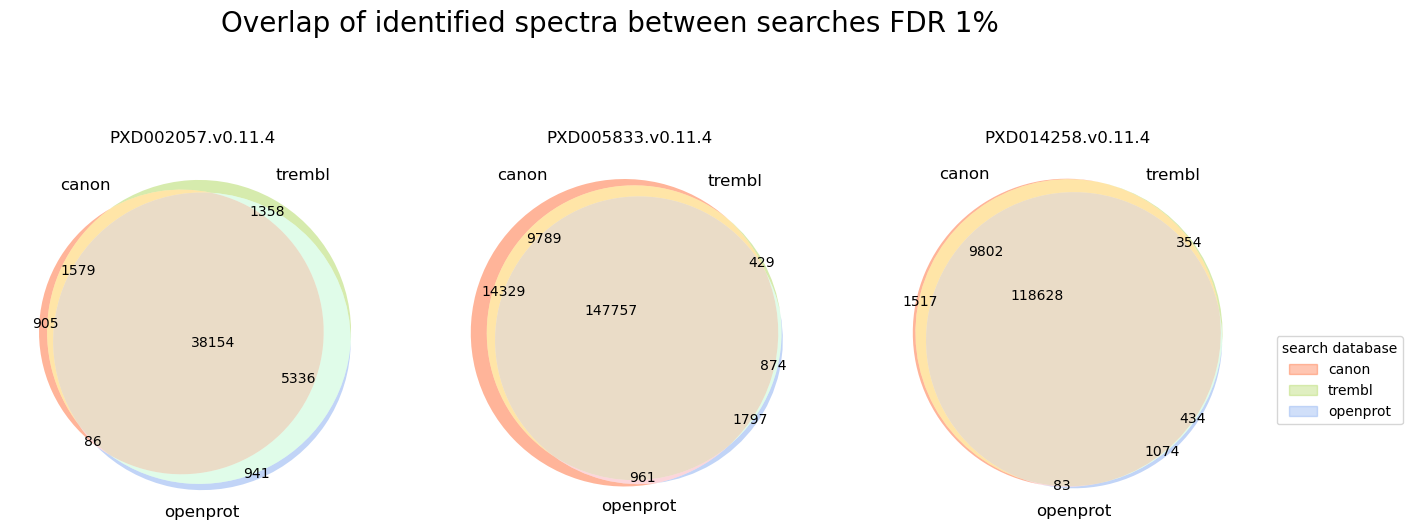

In [22]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified spectra between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(combined_first_datasets):
    dfs=list(combined_first_datasets[dataset_name].values())
    databases=list(combined_first_datasets[dataset_name].keys())
    venn3([set(dfs[0].spectrum_title),set(dfs[1].spectrum_title),set(dfs[2].spectrum_title)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

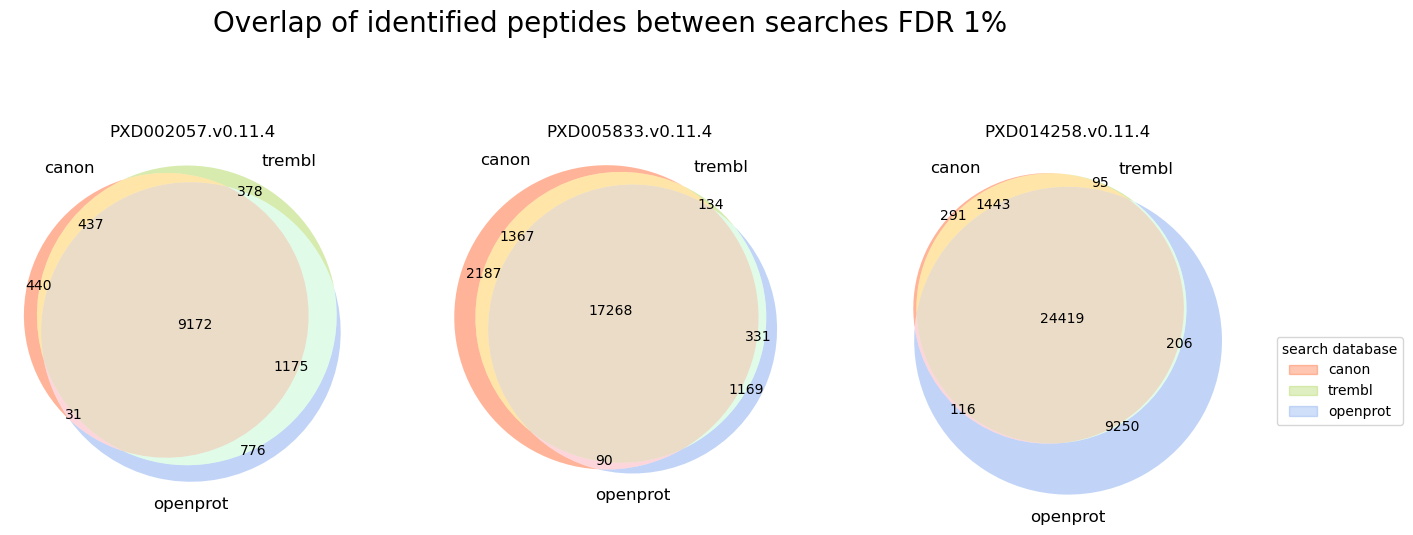

In [23]:
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, figsize=(16,8))
fig.suptitle('Overlap of identified peptides between searches FDR 1%',size=20, y=0.9);
for i, dataset_name in enumerate(combined_peptides_datasets):
    dfs=list(combined_peptides_datasets[dataset_name].values())
    databases=list(combined_peptides_datasets[dataset_name].keys())
    venn3([set(dfs[0].database_peptide),set(dfs[1].database_peptide),set(dfs[2].database_peptide)], ax=axes[i],
      set_labels=[databases[0],databases[1],databases[2]], set_colors=(project_palette[databases[0]],project_palette[databases[1]],project_palette[databases[2]]))
    axes[i].set_title(f"{dataset_name}")
p=[]
for l,c in project_palette.items():
    p.append(mpatches.Patch(color=c, label=l,alpha=0.3))  
fig.legend(handles=p, title="search database",loc='upper right',bbox_to_anchor=(1, 0.5));

### Peptide & protein class

In [24]:
#on psm level

for dataset_name in combined_first_datasets:
    for database in ["canon","trembl","openprot"]:
        df=combined_first_datasets[dataset_name][database]
        df["peptide_class"]=df.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
        df["peptide_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
        df["protein_class"]=df.peptide_class.apply(lambda x: io.classify_protbypep_io(x))
        df["protein_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["protein_class"],axis=1)
        combined_first_datasets[dataset_name][database]=df

/tmp/ipykernel_531118/1969645253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["peptide_class"]=df.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
/tmp/ipykernel_531118/1969645253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["peptide_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
/tmp/ipykernel_531118/1969645253.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [25]:
with open('combined_first_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_first_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
combined_first_datasets=pickle.load(open('combined_first_datasets.pickle', 'rb'))

In [26]:
#on peptide level 

for source in combined_peptides_datasets:
    df=combined_peptides_datasets[source]['openprot']
    df["peptide_class"]=df.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
    df["peptide_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
    df["protein_class"]=df.peptide_class.apply(lambda x: io.classify_protbypep_io(x))
    df["protein_class"]=df.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["protein_class"],axis=1)
    combined_peptides_datasets[source]['openprot']=df

In [27]:
with open('combined_peptides_datasets.pickle', 'wb') as handle:
    pickle.dump(combined_peptides_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
combined_peptides_datasets=pickle.load(open('combined_peptides_datasets.pickle', 'rb'))

In [28]:
#the count of shared and proteotypic peptides

pepsharedproteotyp_df=pd.DataFrame(columns=["pipeline","database","peptide_class","value"])
for database in ["canon","trembl","openprot"]:    
    df=pd.concat([combined_first_datasets[dataset_name][database] for dataset_name in combined_first_datasets])
    ###df=df[(df["database"]=="T")]
    counts=Counter(df.drop_duplicates(["database_peptide"]).peptide_class)
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["ionbot",database,"shared",np.sum([val for key,val in counts.items() if "shared" in key])]
    pepsharedproteotyp_df.loc[len(pepsharedproteotyp_df)]=["ionbot",database,"proteotypic",np.sum([val for key,val in counts.items() if "unique" in key])]

In [29]:
pepsharedproteotyp_df.to_pickle("ionbot_peptype_df.pkl")

#### Save filtered psm and peptide level to share

In [ ]:
#save_hybrid="./oui_discovery_hybrid_filtered_ionbot_open/"
#
#for dataset_name in combined_first_datasets:
#    for database in combined_first_datasets[dataset_name]:
#        df=combined_first_datasets[dataset_name][database]
#        df.to_csv(f"{save_hybrid}{dataset_name}-{database}-byexperiment-hybrid-filtered-psm.csv",index=False)
#for dataset_name in combined_peptides_datasets:
#    for database in combined_peptides_datasets[dataset_name]:
#        df=combined_peptides_datasets[dataset_name][database]
#        df.to_csv(f"{save_hybrid}{dataset_name}-{database}-byexperiment-hybrid-filtered-pep.csv",index=False)

### Identification rate by search

In [30]:
def get_idrate(mgfFiles, df):    
    IDrate={}
    for file in mgfFiles:
        #print(file.split("."))
        print(file,len(df[df["spectrum_file"].str.contains(file.replace('.RAW.mgf', '.mgf').replace("_merged.mgf",""))]))
        #file=file.replace('.RAW.mgf', '.mgf')
        IDrate[file]=len(df[df["spectrum_file"].str.contains(file.replace('.RAW.mgf', '.mgf').replace("_merged.mgf",""))])/mgfFiles[file]
    return IDrate

In [31]:
idrate_datasets={"PXD002057.v0.11.4":0,"PXD005833.v0.11.4":0,"PXD014258.v0.11.4":0}
for dataset_name in combined_first_datasets:
    idrate_med={"canon":0,"trembl":0,"openprot":0}
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets[key]
    for database in idrate_med:
        df=combined_first_datasets[dataset_name][database]
        ##dff=df[df["database"]=="T"]
        if dataset_name=="PXD002057.v0.11.4" or dataset_name=="PXD005833.v0.11.4":
            idrate_med[database]=list(get_idrate(mgfspectraN, df).values())
        else:
            n=5
            #n= 2 if dataset_name=="PXD005833.v0.11.4" else 5
            #mean neighboring values - fractions
            r=list(get_idrate(mgfspectraN, df).values())
            idrate_med[database]=[np.mean(r[x:x+n]) for x in range(0, len(r), n)]  
    idrate_datasets[dataset_name]=idrate_med

130327_o2_03_hu_C2_2hr.mgf 4114
130327_o2_04_hu_P2_2hr.mgf 8432
130327_o2_06_hu_P3_2hr.mgf 8487
130327_o2_01_hu_C1_2hr.mgf 5686
130327_o2_05_hu_C3_2hr.mgf 4387
130327_o2_02_hu_P1_2hr.mgf 9618
130327_o2_03_hu_C2_2hr.mgf 4794
130327_o2_04_hu_P2_2hr.mgf 9497
130327_o2_06_hu_P3_2hr.mgf 9822
130327_o2_01_hu_C1_2hr.mgf 6420
130327_o2_05_hu_C3_2hr.mgf 5030
130327_o2_02_hu_P1_2hr.mgf 10864
130327_o2_03_hu_C2_2hr.mgf 4521
130327_o2_04_hu_P2_2hr.mgf 9092
130327_o2_06_hu_P3_2hr.mgf 9361
130327_o2_01_hu_C1_2hr.mgf 6195
130327_o2_05_hu_C3_2hr.mgf 4875
130327_o2_02_hu_P1_2hr.mgf 10473
AM10.mgf 11483
AM17.mgf 9905
AM19.mgf 13341
AM18.mgf 11110
AM16.mgf 14244
AM11.mgf 11834
AM7.mgf 9099
AM9.mgf 12250
AM20.mgf 10276
AM12.mgf 13194
AM15.mgf 10801
AM8.mgf 10621
AM14.mgf 12585
AM13.mgf 12465
AM21.mgf 9628
AM10.mgf 10707
AM17.mgf 9099
AM19.mgf 12183
AM18.mgf 10086
AM16.mgf 13355
AM11.mgf 11032
AM7.mgf 8126
AM9.mgf 11284
AM20.mgf 9484
AM12.mgf 12173
AM15.mgf 9935
AM8.mgf 9562
AM14.mgf 11617
AM13.mgf 11485
A

In [32]:
idrate_datasets_df=pd.DataFrame(columns=["pipline","sample","database","value"])
for dataset in idrate_datasets:
    for database in idrate_datasets[dataset]:
        for i,val in enumerate(idrate_datasets[dataset][database]):
            idrate_datasets_df.loc[len(idrate_datasets_df)]=["ionbot",f"{dataset}_{i}",database,val]
idrate_datasets_df.to_pickle("ionbot_idrate_datasets_df.pkl")

### Identification rate by peptide class

In [33]:
#as tpp does not save spectra by separate file (but merged, input), then add corresponding files n spectra
mgfspectraN_datasets_tpp=mgfspectraN_datasets.copy()
###mgfspectraN_datasets_tpp['PXD005833.v0.11.4']={f'sample_{i}_merged.mgf':mgfspectraN_datasets['PXD005833.v0.11.4'][f'b1369p080_sample_{i}_a.mgf']+mgfspectraN_datasets['PXD005833.v0.11.4'][f'b1369p080_sample_{i}_b.mgf'] for i in ["01","02","03","04","05","06","07","08","09","10","11","12","13","14"]}
tmp={}
for i in ["ESC-HF-Sample-BT474","ESC-HF-SampleHela","ESC-HF-Sample-MCF"]:
    if "BT474" not in i:
        tmp[f"{i}_merged.mgf"]=int(np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}{j}.RAW.mgf"] for j in range(1,6)]))
    else:
        tmp[f"{i}_merged.mgf"]=int(np.sum([mgfspectraN_datasets['PXD014258.v0.11.4'][f"{i}_{j}.RAW.mgf"] for j in range(1,6)]))
mgfspectraN_datasets_tpp['PXD014258.v0.11.4']=tmp
#mgfspectraN_datasets_tpp

In [34]:
del mgfspectraN_datasets_tpp['PXD003594.v0.11.4']

In [35]:
idrate_PEPCL_datasets_df=pd.DataFrame(columns=["pipeline","dataset","peptide_class","value"])
pepcl_order=["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
datasets_index=[f"{dataset_name}_{i}" for dataset_name,vals in mgfspectraN_datasets_tpp.items() for i in range(len(vals))]
idrate_PEPCL_datasets_df["pipeline"]=["ionbot"]*len(pepcl_order)*len(datasets_index)
idrate_PEPCL_datasets_df["dataset"]=datasets_index*len(pepcl_order)
idrate_PEPCL_datasets_df["peptide_class"]=sorted(pepcl_order*len(datasets_index))

for dataset_name in combined_first_datasets: #combined_peptides_datasets
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    database="openprot"
    df=combined_first_datasets[dataset_name][database]
    ##df=df[df.peptide_class!="Decoy"]
    for peptide_class in pepcl_order:        
        values=list(get_idrate(mgfspectraN, df[df.peptide_class==peptide_class]).values())
        #print(len(values),values)
        idrate_PEPCL_datasets_df.loc[(idrate_PEPCL_datasets_df.dataset.str.contains(dataset_name.replace(".v0.11.4","")))&
            (idrate_PEPCL_datasets_df.peptide_class==peptide_class),"value"]=values
idrate_PEPCL_datasets_df.to_pickle("ionbot_PEPCL_idrate_datasets_df.pkl")

130327_o2_03_hu_C2_2hr.mgf 158
130327_o2_04_hu_P2_2hr.mgf 185
130327_o2_06_hu_P3_2hr.mgf 157
130327_o2_01_hu_C1_2hr.mgf 227
130327_o2_05_hu_C3_2hr.mgf 158
130327_o2_02_hu_P1_2hr.mgf 200
130327_o2_03_hu_C2_2hr.mgf 21
130327_o2_04_hu_P2_2hr.mgf 27
130327_o2_06_hu_P3_2hr.mgf 25
130327_o2_01_hu_C1_2hr.mgf 25
130327_o2_05_hu_C3_2hr.mgf 17
130327_o2_02_hu_P1_2hr.mgf 26
130327_o2_03_hu_C2_2hr.mgf 283
130327_o2_04_hu_P2_2hr.mgf 497
130327_o2_06_hu_P3_2hr.mgf 515
130327_o2_01_hu_C1_2hr.mgf 408
130327_o2_05_hu_C3_2hr.mgf 317
130327_o2_02_hu_P1_2hr.mgf 549
130327_o2_03_hu_C2_2hr.mgf 1508
130327_o2_04_hu_P2_2hr.mgf 3388
130327_o2_06_hu_P3_2hr.mgf 3552
130327_o2_01_hu_C1_2hr.mgf 2020
130327_o2_05_hu_C3_2hr.mgf 1591
130327_o2_02_hu_P1_2hr.mgf 3898
130327_o2_03_hu_C2_2hr.mgf 2551
130327_o2_04_hu_P2_2hr.mgf 4995
130327_o2_06_hu_P3_2hr.mgf 5112
130327_o2_01_hu_C1_2hr.mgf 3515
130327_o2_05_hu_C3_2hr.mgf 2792
130327_o2_02_hu_P1_2hr.mgf 5800
AM10.mgf 104
AM17.mgf 125
AM19.mgf 162
AM18.mgf 117
AM16.mgf 173

In [36]:
#how many psms matched peptides of these classes

pipeline="ionbot"
pepcl_n_psm={k:0 for k in ["Canon_unique","Shared","NonCanon_unique"]}
for dataset in combined_first_datasets:
    psm_df=combined_first_datasets[dataset]["openprot"]
    pep_df=combined_peptides_datasets[dataset_name]["openprot"]
    for peptide_class in ["Canon_unique","Shared","NonCanon_unique"]:
        pcl=peptide_classes[peptide_class]
        n=len(psm_df[psm_df.database_peptide.isin(pep_df[pep_df.peptide_class.isin(pcl)].database_peptide.tolist())])
        pepcl_n_psm[peptide_class]+=n

In [37]:
{k:(v/np.sum(list(pepcl_n_psm.values())))*100 for k,v in pepcl_n_psm.items()}

{'Canon_unique': np.float64(37.168629581162605),
 'Shared': np.float64(61.86555064484005),
 'NonCanon_unique': np.float64(0.96581977399735)}

### Peptides' reproducability

In [38]:
# across all samples

In [39]:
peptides_across_samples_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    peptides_across_samples_l=[]
    for dataset_name in combined_peptides_datasets:
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=peptides_across_samples_l+list(df.drop_duplicates(["database_peptide","spectrum_file"]).database_peptide)
        
    peptides_across_samples_d=Counter(peptides_across_samples_l)
    peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/23 #number of samples
    #print(set(peptides_across_samples))
    keys=list(peptides_across_samples_d.keys())
    for i,row in enumerate(peptides_across_samples):
        peptides_across_samples_df.loc[len(peptides_across_samples_df)]=["ionbot",keys[i],peptide_class,row]

In [40]:
peptides_across_samples_df.to_pickle("ionbot_peptides_across_samples_df.pkl")

In [41]:
# across samples of same PXD

In [42]:
peptides_across_samples_PXD_df=pd.DataFrame(columns=["pipeline","peptide","class","value"])
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    #peptides_across_samples_l=[]
    for dataset_name in combined_peptides_datasets:
        key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
        mgfspectraN=mgfspectraN_datasets_tpp[key]
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.drop_duplicates(["database_peptide","spectrum_file"]).database_peptide)
        
        peptides_across_samples_d=Counter(peptides_across_samples_l)
        peptides_across_samples=np.array(list(peptides_across_samples_d.values()))/len(mgfspectraN) #number of samples
        keys=list(peptides_across_samples_d.keys())
        for i,row in enumerate(peptides_across_samples):
            peptides_across_samples_PXD_df.loc[len(peptides_across_samples_PXD_df)]=["ionbot",keys[i],peptide_class,row]

In [43]:
peptides_across_samples_PXD_df.to_pickle("ionbot_peptides_across_samples_PXD_df.pkl")

In [ ]:
#count by PXD

tmp_all={}
peptides_across_samples_PEP_df=pd.DataFrame(columns=["pipeline","PXD","peptide_class","value","count"])
for dataset_name in combined_first_datasets:
    tmp_all[dataset_name]={}
    for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:#("Canon_unique", "NonCanon_unique", "Shared"):
        df=combined_first_datasets[dataset_name]["openprot"]
        df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
        peptides_across_samples_l=list(df.database_peptide.unique())
        tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
        for spectrum_file in tmp.columns:
            tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].database_peptide.unique() for pep in tmp.index]
        tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,1,len(tmp[tmp["count"]==1])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,2,len(tmp[tmp["count"]==2])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,3,len(tmp[tmp["count"]==3])]
        peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot",dataset_name,peptide_class,4,len(tmp[tmp["count"]>3])]
        tmp_all[dataset_name][peptide_class]=tmp

In [ ]:
#all

#add all
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']:
    df=pd.concat([combined_first_datasets[dataset_name]["openprot"] for dataset_name in combined_first_datasets])
    df=df[(df["database"]=="T")&(df["peptide_class"]==peptide_class)]
    peptides_across_samples_l=list(df.database_peptide.unique())
    tmp=pd.DataFrame(index=peptides_across_samples_l,columns=df.spectrum_file.unique())
    for spectrum_file in tmp.columns:
        tmp[spectrum_file]=[pep in df[df.spectrum_file==spectrum_file].database_peptide.unique() for pep in tmp.index]
    tmp["count"]=tmp.apply(lambda x: Counter(x)[True] ,axis=1)
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,1,len(tmp[tmp["count"]==1])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,2,len(tmp[tmp["count"]==2])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,3,len(tmp[tmp["count"]==3])]
    peptides_across_samples_PEP_df.loc[len(peptides_across_samples_PEP_df)]=["ionbot","all",peptide_class,4,len(tmp[tmp["count"]>3])]

In [ ]:
peptides_across_samples_PEP_df.to_pickle("ionbot_peptides_across_samples_PEP_df.pkl")

### Number of PSMs per peptide class

In [ ]:
#here I count same peptide in diff samples separatly
pepcl_psm_frq={"peptide":[],"peptide_class":[],"psm_num":[]}
for peptide_class in ["unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']: #("Canon_unique", "NonCanon_unique", "Shared")
    peps_dst=[]
    for dataset_name in combined_peptides_datasets:
        df=combined_peptides_datasets[dataset_name]["openprot"]
        df=df[(df["peptide_class"]==peptide_class)]
        peps_dst=peps_dst+list(df.database_peptide)
    psm_dfs=pd.concat([subdict["openprot"] for dataset,subdict in combined_first_datasets.items()])
    peps_count=Counter(psm_dfs[psm_dfs.database_peptide.isin(peps_dst)].database_peptide)
    peps_count_v=list(list(peps_count.values()))
    pepcl_psm_frq["peptide"]=pepcl_psm_frq["peptide"]+list(list(peps_count.keys()))
    pepcl_psm_frq["peptide_class"]=pepcl_psm_frq["peptide_class"]+[peptide_class]*len(peps_count_v)
    pepcl_psm_frq["psm_num"]=pepcl_psm_frq["psm_num"]+[p for p in peps_count_v] #np.log(p)
pepcl_psm_frq=pd.DataFrame(pepcl_psm_frq)
pepcl_psm_frq["pipeline"]="ionbot"
pepcl_psm_frq["bin"]=np.nan
for bin,group in enumerate([[1],[2],list(range(3,5+1)),list(range(5,10+1)),list(range(10,15+1)),list(range(15,20+1))]):
    pepcl_psm_frq.loc[pepcl_psm_frq.psm_num.isin(group),"bin"]=bin

In [ ]:
pepcl_psm_frq.to_pickle("ionbot_pepcl_psm_frq.pkl")

In [ ]:
########----------wait-new-inference

### Proteins

In [ ]:
#use proteins infered by Enrico
#unarchive
#proteins_dir=f"{working_dir}proteins/"
#for file in glob.glob(f"{proteins_dir}*.gz"):
#    with gzip.open(file, 'rb') as f_in:
#        with open(file[:-3], 'wb') as f_out:
#            shutil.copyfileobj(f_in, f_out)

In [ ]:
#combined_proteins_ocacam=pd.read_csv(f"{proteins_dir}identified-protein-groups-all-datasets.csv")

In [ ]:
combined_proteins_ocacam=pd.DataFrame()#{"PXD002057.v0.11.4":0,"PXD005833.v0.11.4":0,"PXD014258.v0.11.4":0}
for dataset_name in combined_peptides_datasets:
    databases=["canon","trembl","openprot"]
    for database in databases:
        df=io.combine_ionbot(working_folder, dataset_name, f"-{database}","sample_protein_groups_Occam.csv")
        df.reset_index(inplace=True,drop=True)
        #df_f=df.loc[df["group_qval"]<0.01,:]
        #df_f=df_f.loc[~((df_f["proteins"].str.contains("CONTAMINANT")) | (df_f["proteins"].str.contains("contaminant")))]
        combined_proteins_ocacam=pd.concat([combined_proteins_ocacam,df])
combined_proteins_ocacam.reset_index(inplace=True,drop=True)

In [ ]:
#fix spectrum file
fix2057tr={'130327_o2_06_trembl': '130327_o2_06_hu_P3_2hr.mgf',
  '130327_o2_05_trembl': '130327_o2_05_hu_C3_2hr.mgf',
  '130327_o2_03_trembl': '130327_o2_03_hu_C2_2hr.mgf',
  '130327_o2_01_trembl': '130327_o2_01_hu_C1_2hr.mgf',
  '130327_o2_02_trembl': '130327_o2_02_hu_P1_2hr.mgf',
  '130327_o2_04_trembl': '130327_o2_04_hu_P2_2hr.mgf'}
a=pd.DataFrame()
for (dataset,database,spectrum_file),group in combined_proteins_ocacam.groupby(["PXD","searchDB","spectrum_file"]):
    if dataset=="PXD002057.v0.11.4" and database=="trembl":
        for experiment,group_2 in group.groupby("experiment"):
            group_2["spectrum_file"]=fix2057tr[experiment]
            a=pd.concat([a,group_2])
    else:
        group["spectrum_file"]=fix_spectrum_file[dataset][database][spectrum_file]
        a=pd.concat([a,group])
combined_proteins_ocacam=a

In [ ]:
#filter by qval
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam['group_qval']<0.01]

In [ ]:
#drop decoys
combined_proteins_ocacam=combined_proteins_ocacam[combined_proteins_ocacam.database!="D"]

In [ ]:
#classify: 1 protein/group

combined_proteins_ocacam["level"]=np.nan
for (PXD, spectrum_file, database ), group in combined_proteins_ocacam.groupby(['PXD','spectrum_file','searchDB',]):
    df=combined_first_datasets[PXD][database]
    df=df[df.spectrum_file==spectrum_file]
    combined_proteins_ocacam.loc[(combined_proteins_ocacam.PXD==PXD)&(
        combined_proteins_ocacam.spectrum_file==spectrum_file)&(
        combined_proteins_ocacam.searchDB==database),"level"]=group.proteins.apply(lambda x: "Group" if "," in x else "Singleton")
    #group.proteins.apply(lambda x: "Singleton" if any( not "||" in psm for psm in df[df.proteins.str.contains(x)].proteins.value_counts().index) else "Group")

In [ ]:
combined_proteins_ocacam[["searchDB","level"]].value_counts()

In [ ]:
combined_proteins_ocacam.to_pickle("ionbot_combined_proteins_ocacam.pickle")

In [ ]:
combined_proteins_ocacam=pd.read_pickle("ionbot_combined_proteins_ocacam.pickle")

In [ ]:
combined_proteins_ocacam[combined_proteins_ocacam.proteins.str.contains("B4DNT8")]

In [ ]:
def get_nonc_prots(pep_df,mode):
    return list(set([io.extract_accession(p, mode) for p in pep_df[pep_df.peptide_class.isin(["unique_to_Noncanon"])].proteins]))

In [ ]:
combined_proteins_ocacam_newop=combined_proteins_ocacam.copy(deep=True)
#filter out noncanonical proteins from combined_proteins_ocacam
for (dataset,spectrum_file),group in combined_proteins_ocacam[combined_proteins_ocacam.searchDB=="openprot"].groupby(["PXD","spectrum_file"]):
    print(spectrum_file)
    spectrum_file_mod=spectrum_file.rstrip(".gzip").replace("-openprot","").replace("_openprot","")
    drop_op=group[(group.FDRGroup=="NonCanon")].index
    combined_proteins_ocacam_newop.drop(drop_op,axis=0,inplace=True)
    pep_df=combined_peptides_datasets[dataset]["openprot"]
    pep_df=pep_df[pep_df.peptide_class!="Decoy"]
    op_ncprot=get_nonc_prots(pep_df.loc[pep_df.spectrum_file.str.contains(spectrum_file_mod)],"closed")
    tmp=pd.DataFrame({col:(op_ncprot if col=="proteins" 
                           else [dataset]*len(op_ncprot) if col=="PXD" 
                           else [spectrum_file]*len(op_ncprot) if col=="experiment"
                           else ["NonCanon"]*len(op_ncprot) if col=="FDRGroup"
                           else ["openprot"]*len(op_ncprot) if col=="searchDB"
                           else ["Singleton"]*len(op_ncprot) if col=="level"
                           else ["T"]*len(op_ncprot) if col=="database"
                           else [np.nan]*len(op_ncprot)) for col in group.columns})
    print(spectrum_file,len(tmp))
    combined_proteins_ocacam_newop=pd.concat([combined_proteins_ocacam_newop,tmp])
combined_proteins_ocacam_newop.reset_index(drop=True,inplace=True)

In [ ]:
#drop previous non-canonical proteins

combined_proteins_ocacam_newop=combined_proteins_ocacam_newop[~((combined_proteins_ocacam_newop.FDRGroup=="NonCanon")&(combined_proteins_ocacam_newop.psm_score.isna()==False))]

In [ ]:
#also drop non-canonical proteins from Groups, because we concider them non-identified on protein level

for i,row in combined_proteins_ocacam_newop.iterrows():
    if row["level"]=="Group":
        nc=[ prot.startswith(("IP_","II_")) for prot in row["proteins"].split(",")]
        if all(nc): #delet nc groups
            combined_proteins_ocacam_newop.drop(i,axis=0,inplace=True)
        else:
            combined_proteins_ocacam_newop.loc[i,"proteins"]=",".join([prot for prot,isnc in zip(row["proteins"].split(","),nc) if not isnc])

In [ ]:
combined_proteins_ocacam_newop[(combined_proteins_ocacam_newop.FDRGroup=="NonCanon")].proteins.apply(lambda x: "," in x ).value_counts()

In [ ]:
combined_proteins_ocacam_newop.to_pickle("open_combined_proteins_ocacam_newop.pkl")

In [ ]:
# Number of proteins identified with ionbot by search

bysearch_proteins=pd.DataFrame(columns=["pipeline","database","group","value"])
for database,group in combined_proteins_ocacam_newop.groupby(["searchDB"]):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    bysearch_proteins.loc[len(bysearch_proteins)]=["ionbot",database[0],"singletons",len(singletons)]
    bysearch_proteins.loc[len(bysearch_proteins)]=["ionbot",database[0],"indistinguishable proteins",len(uplim-singletons)]
bysearch_proteins.to_pickle("ionbot_bysearch_proteins.pkl")

In [ ]:
bysearch_proteins

### Proteins reproducability

In [ ]:
#across all samples 

prot_reproduce_ionbot=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for database, group in combined_proteins_ocacam_newop.groupby(["searchDB"]):
    group.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group[group.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    frq_sig={p:n/24 for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group[group.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/24 for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["ionbot"]*L,"database":[database[0]]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_ionbot=pd.concat([prot_reproduce_ionbot,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_ionbot.to_pickle("ionbot_prot_reproduce.pkl")

In [ ]:
a=prot_reproduce_ionbot[(prot_reproduce_ionbot.database=="openprot")&(prot_reproduce_ionbot.protein.apply(lambda x: x.startswith("II_") or x.startswith("IP_")))]
a.frequency.mean()

In [ ]:
#across samples of same PXD

prot_reproduce_PXD_ionbot=pd.DataFrame(columns=["pipeline","database","level","protein","frequency"]);
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    frq_sig={p:n/len(mgfspectraN) for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n/len(mgfspectraN) for p,n in counts_uplim.items()}
    L=len(frq_sig)+len(frq_uplim)
    tmp={"pipeline":["ionbot"]*L,"database":[database]*L,"level":["razor"]*len(frq_sig)+["from group"]*len(frq_uplim),
         "protein":list(frq_sig.keys())+list(frq_uplim.keys()),"frequency":list(frq_sig.values())+list(frq_uplim.values())
        }
    prot_reproduce_PXD_ionbot=pd.concat([prot_reproduce_PXD_ionbot,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_PXD_ionbot.to_pickle("ionbot_prot_reproduce_PXD.pkl")

In [ ]:
#across samples of same PXD, counts

values=list(range(1,4))
prot_reproduce_PXD_ionbot_counts=pd.DataFrame(columns=["pipeline","PXD","database","level","value","count"])
for (database, PXD), group_pxd in combined_proteins_ocacam_newop.groupby(["searchDB","PXD"]):
    group_pxd.drop_duplicates(["proteins","experiment"],inplace=True)
    group_sig=group_pxd[group_pxd.level=="Singleton"]    
    counts_sig=group_sig.proteins.value_counts().to_dict()
    key=[ds for ds in mgfspectraN_datasets if dataset_name in ds][0]
    mgfspectraN=mgfspectraN_datasets_tpp[key]
    frq_sig={p:n for p,n in counts_sig.items()}
    prot_sing=set(counts_sig.keys())
    #it treaky, because in different samples protein can be in group of several entries
    group_uplim=group_pxd[group_pxd.level=="Group"]
    prot_uplim_exp={file:set([p for i,row in sub.iterrows() for p in row["proteins"].split(",")]) for file,sub in group_uplim.groupby("experiment")}
    #subtract singeltons
    prot_uplim_corr={file:list(prots-set(group_sig[group_sig.experiment==file].proteins.tolist())) for file,prots in prot_uplim_exp.items()}      
    #unlist
    counts_uplim=Counter([el for l in prot_uplim_corr.values() for el in l])
    frq_uplim={p:n for p,n in counts_uplim.items()}
    ###L=len(frq_sig)+len(frq_uplim)
    value_counts_sig=Counter(list(frq_sig.values()))
    value_counts_uplim=Counter(list(frq_uplim.values()))
    L=len(values)*2
    tmp={"pipeline":["ionbot"]*L,"PXD":[PXD.replace("-closed","")]*L,"database":[database]*L,"level":["razor"]*len(values)+["from group"]*len(values),"value":values*2,
         "count":[value_counts_sig[i] if i<3 else np.sum([v for k,v in value_counts_sig.items() if k>=3]) for i in values]+[value_counts_uplim[i] if i<3 else np.sum([v for k,v in value_counts_uplim.items() if k>=3]) for i in values]
        }
    #break
    prot_reproduce_PXD_ionbot_counts=pd.concat([prot_reproduce_PXD_ionbot_counts,pd.DataFrame(tmp)])

In [ ]:
#add all

values=list(range(1,4))
for (database,level),group in prot_reproduce_ionbot.groupby(["database","level"]):
    counts={k*24:v for k,v in dict(group.frequency.value_counts()).items()}
    L=len(values)
    tmp={"pipeline":["ionbot"]*L,"PXD":["all"]*L,"database":[database]*L,"level":[level]*len(values),"value":values,
         "count":[0 if i not in counts.keys() else counts[i] if i<3 else np.sum([v for k,v in counts.items() if k>=3]) for i in values]
        }
    prot_reproduce_PXD_ionbot_counts=pd.concat([prot_reproduce_PXD_ionbot_counts,pd.DataFrame(tmp)])

In [ ]:
prot_reproduce_PXD_ionbot_counts.to_pickle("ionbot_protrepr_PXD_counts.pkl")

In [ ]:
prot_reproduce_PXD_ionbot_counts[prot_reproduce_PXD_ionbot_counts.PXD=='PXD014258.v0.11.4']

### Number of proteins per protein class

In [ ]:
byprotclass_proteins=pd.DataFrame(columns=["pipeline","search","protein_class","group","value"])
for (search,protein_class),group in combined_proteins_ocacam_newop.groupby(["searchDB","FDRGroup"]):
    group_sing=group[group.level=="Singleton"]
    group_uplim=group[group.level=="Group"]
    singletons=set(group_sing.proteins.tolist())
    uplim=set([p for g in group_uplim.proteins.tolist() for p in g.split(",")])
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["ionbot",search,protein_class,"singletons",len(singletons)]
    byprotclass_proteins.loc[len(byprotclass_proteins)]=["ionbot",search,protein_class,"indistinguishable proteins",len(uplim-singletons)]
byprotclass_proteins.to_pickle("ionbot_byprotclass_proteins.pkl")

### Number of peptides & PSMs per protein per protein class

In [ ]:
peptide_df=pd.concat([combined_peptides_datasets[dataset_name]["openprot"] for dataset_name in combined_peptides_datasets])
peptide_df['proteins_list'] = peptide_df.proteins.apply(lambda x: [io.extract_accession(p, "closed") for p in x.split("||")])
peptide_df = peptide_df.explode('proteins_list').reset_index(drop=True)
#peptide_df.to_pickle("protein_expended_combined_peptides.pkl")
psm_df=pd.concat([combined_first_datasets[dataset_name]["openprot"] for dataset_name in combined_first_datasets])
psm_df['proteins_list'] = psm_df.proteins.apply(lambda x: [io.extract_accession(p, "closed") for p in x.split("||")])
psm_df = psm_df.explode('proteins_list').reset_index(drop=True)
#psm_df.to_pickle("protein_expended_combined_first.pkl")

In [ ]:
peptide_df.to_pickle("protein_expended_combined_peptides.pkl")
psm_df.to_pickle("protein_expended_combined_first.pkl")

In [ ]:
#peptide_df=pd.read_pickle("protein_expended_combined_peptides.pkl")
#peptide_df.drop_duplicates(['database_peptide','proteins_list'],inplace=True)

In [ ]:
#psm_df=pd.read_pickle("protein_expended_combined_first.pkl")

In [ ]:
#proteins_pep_df=pd.DataFrame(columns=["proteins_","protein_class"])#,"Unique","Shared"])
#proteins_psm_df=pd.DataFrame(columns=["proteins_","protein_class"])#,"Unique","Shared"])
#
#for protein_class,group in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.searchDB=="openprot"].groupby(["FDRGroup"]):
#    print(protein_class)
#    if protein_class[0]=="Canon": pep_class_pref="Canon"                
#    elif protein_class[0]=="NonCanon": pep_class_pref="Noncanon"
#    proteins=group[group.level=="Singleton"].proteins.tolist()+[p for g in group[group.level=="Group"].proteins.tolist() for p in g.split(",")]
#    print("add prots",len(list(set(proteins))))
#    print("IP_623048" in proteins)
#    cl_unique_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,f"unique_to_{pep_class_pref}",proteins)
#    cl_shin_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,f"shared_in_{pep_class_pref}",proteins)
#    cl_shared_pep_df_counts=io.get_frompepdf_pepcounts_io(peptide_df,"shared_btw_can_noncan",proteins)
#    print("add pep counts",len(cl_shared_pep_df_counts))
#    add_pr=set(proteins)
#    prot_pep_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class[0]]*len(add_pr),
#                 "unique_to_class":list(cl_unique_pep_df_counts.values()),
#                "shared_in_class":list(cl_shin_pep_df_counts.values()),
#                 "shared_btw_classes":list(cl_shared_pep_df_counts.values())})
#    
#    proteins_pep_df=pd.concat([proteins_pep_df,prot_pep_df])
#    print(proteins_pep_df.head())
#    #psm    
#    cl_unique_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,f"unique_to_{pep_class_pref}",proteins)
#    cl_shin_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,f"shared_in_{pep_class_pref}",proteins)
#    cl_shared_psm_df_counts=io.get_frompsmdf_psmcounts_io(peptide_df,psm_df,"shared_btw_can_noncan",proteins)
#    prot_psm_df=pd.DataFrame({"proteins_":list(add_pr),"protein_class":[protein_class[0]]*len(add_pr),
#                 "unique_to_class":list(cl_unique_psm_df_counts.values()),
#                "shared_in_class":list(cl_shin_psm_df_counts.values()),
#                 "shared_btw_classes":list(cl_shared_psm_df_counts.values())})
#    proteins_psm_df=pd.concat([proteins_psm_df,prot_psm_df])
#
#proteins_pep_df.reset_index(inplace=True, drop=True)
#proteins_psm_df.reset_index(inplace=True, drop=True)

In [ ]:
#concatinate all datasets

combined_first_mega=pd.concat([combined_first_datasets[dataset]["openprot"] for dataset in combined_first_datasets.keys()])
combined_peptides_mega=pd.concat([combined_peptides_datasets[dataset]["openprot"] for dataset in combined_peptides_datasets.keys()])

In [ ]:
#get all proteins

proteins_all=set(combined_proteins_ocacam_newop[(combined_proteins_ocacam_newop.searchDB=="openprot")&
                 (combined_proteins_ocacam_newop.level=="Singleton")].proteins.tolist()+
                 [p for g in combined_proteins_ocacam_newop[(combined_proteins_ocacam_newop.searchDB=="openprot")&
                  (combined_proteins_ocacam_newop.level=="Group")].proteins.tolist() for p in g.split(",")])

#creat the output tables

cols=["proteins","protein_class","unique_to_class","shared_in_class","shared_btw_classes"]
proteins_pep_counts=pd.DataFrame(columns=cols)
proteins_psm_counts=pd.DataFrame(columns=cols)

proteins_pep_counts["proteins"]=list(proteins_all)
proteins_psm_counts["proteins"]=list(proteins_all)

In [ ]:
#caution, runs for a long time
#count psms and peptides per protein (datasets merged)

fill_cols=["protein_class","unique_to_class","shared_in_class","shared_btw_classes"]
for protein in proteins_all:
    #print(protein)
    protein_class=io.classify_protein_byprotname_io(protein)       
    if protein_class=="Canon": pep_class_pref="Canon"                
    elif protein_class=="NonCanon": pep_class_pref="Noncanon"
    found_sp=combined_first_mega[combined_first_mega.proteins.str.contains(protein)]
    sp_class=Counter(found_sp.peptide_class.tolist())
    pep_class=Counter(found_sp.drop_duplicates("database_peptide").peptide_class.tolist())
    #fill table
    proteins_psm_counts.loc[proteins_psm_counts.proteins==protein,fill_cols]=[protein_class,sp_class[f"unique_to_{pep_class_pref}"],
                                                                              sp_class[f"shared_in_{pep_class_pref}"],sp_class["shared_btw_can_noncan"]]

    proteins_pep_counts.loc[proteins_pep_counts.proteins==protein,fill_cols]=[protein_class,pep_class[f"unique_to_{pep_class_pref}"],
                                                                              pep_class[f"shared_in_{pep_class_pref}"],pep_class["shared_btw_can_noncan"]]
    #break

In [ ]:
proteins_pep_counts.to_pickle("ionbot_proteins_pep_df.pkl")
proteins_psm_counts.to_pickle("ionbot_proteins_psm_df.pkl")

In [ ]:
#these are identified from PSMs of lower quality

In [ ]:
proteins_pep_counts["tot"]=proteins_pep_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class","shared_btw_classes"]])),axis=1)
proteins_psm_counts["tot"]=proteins_psm_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class","shared_btw_classes"]])),axis=1)

In [ ]:
len(proteins_pep_counts[proteins_pep_counts.tot==0]),len(proteins_pep_counts)

In [ ]:
len(proteins_psm_counts[proteins_psm_counts.tot==0]),len(proteins_psm_counts)

In [ ]:
#fill the "filtered out" proteins. Use psm level

proteins_pep_counts["isFiltered"]=proteins_psm_counts.tot==0
proteins_psm_counts["isFiltered"]=proteins_psm_counts.tot==0

In [ ]:
len(proteins_psm_counts[proteins_psm_counts.isFiltered])

In [ ]:
proteins_pep_counts["tot_class"]=proteins_pep_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class"]])),axis=1)
proteins_psm_counts["tot_class"]=proteins_psm_counts.apply(lambda x: int(np.sum(x[["unique_to_class","shared_in_class"]])),axis=1)

In [ ]:
proteins_pep_counts[(proteins_pep_counts.protein_class=="NonCanon")&(proteins_pep_counts.tot_class!=0)].tot_class.mean()

In [ ]:
proteins_psm_counts[(proteins_psm_counts.protein_class=="NonCanon")&(proteins_psm_counts.tot_class!=0)].tot_class.mean()

In [ ]:
a=proteins_pep_counts[(proteins_pep_counts.protein_class=="NonCanon")&(proteins_pep_counts.tot_class!=0)]
len(a[(a.unique_to_class>1)])/len(a)

In [ ]:
a=proteins_psm_counts[(proteins_psm_counts.protein_class=="NonCanon")&(proteins_psm_counts.tot_class!=0)]
len(a[(a.unique_to_class>1)])/len(a)

In [ ]:
###########

### Proteotypic peptides coverage

In [ ]:
all_peptide_sequences=pickle.load(open('all_peptide_sequences_OP_7302.pkl', 'rb'))
is_unique=pickle.load(open('is_unique_OP_7302.pkl', 'rb'))

In [ ]:
#get positions of in silico digestion unique peptides
#leave only proteins that were identified
proteins_op=combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.level=="Singleton"].proteins.tolist()+[p for g in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.level=="Group"].proteins.tolist() for p in g.split(",")]
#filterout proteins with shared peptide ["Canon_unique","NonCanon_unique"]
peptide_df_identunique=peptide_df[(peptide_df.peptide_class.isin(peptide_classes["Canon_unique"]+peptide_classes["NonCanon_unique"]))&(peptide_df.proteins_list.isin(set(proteins_op)))]

In [ ]:
peptide_df_identunique["peptide_position"]=peptide_df_identunique["proteins"].apply(lambda x: x.split("((")[1].split("))")[0].split("-"))

In [ ]:
#correct for python indexing
peptide_df_identunique["peptide_position"]=peptide_df_identunique["peptide_position"].apply(lambda x: (int(x[0])-1,int(x[1])-2))

In [ ]:
#filterout non-unique peptides
peptide_df_identunique["shared"]=peptide_df_identunique["proteins"].apply(lambda x: "||" in x )

In [ ]:
peptide_df_identunique=peptide_df_identunique[peptide_df_identunique.shared==False]

In [ ]:
all_peptide_sequences_identunique={}
all_peptide_sequences_prot=[p.split("|")[1] for p in all_peptide_sequences.keys()]
for prot_i in set(peptide_df_identunique.proteins_list.tolist()):
    prot=f'op|{prot_i}|TX=9606'
    peps=all_peptide_sequences[prot]
    peps_unique=[is_unique[p]  for p in peps] #if p in peptide_df_identunique[peptide_df_identunique.proteins_x_expand==prot_i].database_peptide.tolist()
    peps_unique=np.array(peps)[peps_unique]
    all_peptide_sequences_identunique[prot_i]=peps_unique

In [ ]:
all_peptide_sequences_identunique_pos={}
for prot_i,uniquepeps in all_peptide_sequences_identunique.items():
    group=pd.DataFrame({"database_peptide":list(uniquepeps),"peptide_position":[np.nan]*len(uniquepeps)})
    prot_seq=str(OPfasta[f'op|{prot_i}|TX=9606'].seq)
    uniquepeps_pos=[]
    for pep in uniquepeps:
        #print(pep)
        pos=hpp.get_pep_positions(prot_seq,pep)
        if len(pos)>1: pos=[pos[0]]
        uniquepeps_pos=uniquepeps_pos+pos
    group["peptide_position"]=uniquepeps_pos
    all_peptide_sequences_identunique_pos[prot_i]=group

In [ ]:
#get the number of aninoasids coverged with unique peptides
all_peptide_sequences_identunique_pos_wident={}
for prot_i,uniquepeps_df in all_peptide_sequences_identunique_pos.items():
    ident_df=peptide_df_identunique.groupby("proteins_list").get_group(prot_i)
    all_peptide_sequences_identunique_pos_wident[prot_i]=uniquepeps_df.merge(ident_df[["database_peptide","peptide_position"]],how="outer",on="database_peptide")

In [ ]:
unique_peptide_aa_coverege={}
for prot_i,uniquepeps_df in all_peptide_sequences_identunique_pos_wident.items():
    #if peptide not known by in situ, add it
    
    #uniquepeps_df["peptide_position_y"]=uniquepeps_df["peptide_position_y"].apply(lambda x: x if isinstance(x,tuple) else (0,0))
    uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_x"]= uniquepeps_df.loc[uniquepeps_df.peptide_position_x.isna(),"peptide_position_y"]

    _,theory=hpp.find_max_length_in_overlap_groups(uniquepeps_df.peptide_position_x.tolist())
    _,practice=hpp.find_max_length_in_overlap_groups(uniquepeps_df[~uniquepeps_df.peptide_position_y.isna()].peptide_position_y.tolist())#drop nan
    theory_cov=np.sum([abs(rang[0]-rang[1]) for rang in theory])
    practice_cov=np.sum([abs(rang[0]-rang[1]) for rang in practice])
    ratio=practice_cov/theory_cov
    if ratio==np.inf: ratio=1
    unique_peptide_aa_coverege[prot_i]=[ratio] #normalise by number of theoretical peptides

In [ ]:
unique_peptide_aa_coverege_df=pd.DataFrame(unique_peptide_aa_coverege).T
unique_peptide_aa_coverege_df.columns=["value"]
unique_peptide_aa_coverege_df.sort_index(inplace=True)
a=peptide_df_identunique[peptide_df_identunique.proteins_list.isin(unique_peptide_aa_coverege_df.index.tolist())]
a.drop_duplicates("proteins_list",inplace=True,keep="first")
a.sort_values(["proteins_list"],inplace=True)
unique_peptide_aa_coverege_df["peptide_class"]=a["peptide_class"].tolist()
unique_peptide_aa_coverege_df["pipeline"]="ionbot"
unique_peptide_aa_coverege_df.to_pickle("ionbot_unique_peptide_aa_coverege_df.pkl")

### Modification state

In [ ]:
#filtered peptide level
all_peptides=pd.concat([combined_peptides_datasets[dataset]["openprot"][["database_peptide","peptide_class"]] for dataset in combined_peptides_datasets])
#take uniqly peptides
all_peptides.drop_duplicates(inplace=True)
#filtered psm level
all_pep_modf=pd.concat([combined_first_datasets[dataset]["openprot"][["database_peptide","modifications",'unexpected_modification']] for dataset in combined_peptides_datasets])
#unfiltered peptide-modification level
all_pep_modf.drop_duplicates(inplace=True)
#from psm level transfer (so filters by pep level) modifications to peptide level
all_peptides_uniqmod=all_peptides.merge(all_pep_modf,how='inner',on="database_peptide")

In [ ]:
#modification frequency
all_peptides_modfrq=pd.DataFrame(columns=["database_peptide","peptide_class","modification_class"])
for peptide,group in all_peptides_uniqmod.groupby("database_peptide"):
    modification_class=0
    if len(group)==len(group[group.modifications=="Unmodified"]):
        modification_class="OnlyUnmod"
    elif len(group)==len(group[group.modifications!="Unmodified"]):
        modification_class="OnlyMod"
    else:
        modification_class="Both"
    all_peptides_modfrq.loc[len(all_peptides_modfrq)]=[peptide,group.peptide_class.iloc[0],modification_class]   

In [ ]:
peptide_classes

In [ ]:
data=pd.DataFrame(columns=["peptide_class","modification_class","pepcl_pc"])
all_peptides_modfrq_cp=all_peptides_modfrq.copy(deep=True)
all_peptides_modfrq_cp.peptide_class.replace(peptide_classes["Canon_unique"],"Canon_unique",inplace=True)
all_peptides_modfrq_cp.peptide_class.replace(peptide_classes["Shared"],"Shared",inplace=True)
all_peptides_modfrq_cp.peptide_class.replace(peptide_classes["NonCanon_unique"],"NonCanon_unique",inplace=True)
for (peptide_class,modification_class),group in all_peptides_modfrq_cp.groupby(["peptide_class","modification_class"]):
    if peptide_class=="Decoy": continue
    data.loc[len(data)]=[peptide_class,modification_class,
                         (len(group)/len(all_peptides_modfrq_cp[all_peptides_modfrq_cp.peptide_class==peptide_class]))*100]
    print([peptide_class,modification_class,len(group)])
#custom order
#custom_order = ["unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan','shared_in_Noncanon',"unique_to_Noncanon"]
custom_order = ["Canon_unique","Shared","NonCanon_unique"]
data.peptide_class = data.peptide_class.astype("category")
data.peptide_class = data.peptide_class.cat.set_categories(custom_order)
data.sort_values(["peptide_class"],inplace=True)


#x=["Canonical","Shared","Non-canonical"]
x=data.peptide_class.unique()
bottom=None
fig, ax = plt.subplots(layout='constrained',figsize=(8,4))
colors=[]
for modification_class in ["OnlyUnmod","Both","OnlyMod"]:
    row=data.loc[data.modification_class==modification_class,"pepcl_pc"].tolist()
    print(row)
    #reorder so canon, shared, noncanon
    ###row=[row[0],row[2],row[1]]
    attribute= "Only modified" if modification_class=="OnlyMod" else "Only unmodified" if modification_class=="OnlyUnmod" else "Both"
    color=[project_palette2[f"ionbot_canon_unique_{modification_class}"],
                                        project_palette2[f"ionbot_shared_{modification_class}"],
                                        project_palette2[f"ionbot_noncanon_unique_{modification_class}"]]
    colors=colors+color
    ax.bar(x, row, bottom=bottom,label=attribute, color=color)
    
    #annotate
    #for bar in bars:
    #    height = bar.get_height()
    #    xx = bar.get_x() + bar.get_width() / 2
    #    y = (bottom[i] if bottom is not None else 0) + height / 2
    #    ax.text(xx, y, f'{height}', ha='center', va='center', color='black', fontsize=10)
    
    
    ax.set_ylabel("modification status (%)")
    ax.set_ylim(0,101)
    #ax.set_xticks(range(5),["unique to a \ncanonical \nprotein",
    #                        "shared between \ncanonical \nproteins",
    #                        "shared between \ncanonical \nand non-canonical \nproteins",
    #                       "shared between \nnon-canonical \nproteins",
    #                       "unique to a \nnon-canonical \nprotein"],fontsize=10)
    ax.set_xticks(range(len(x)),["Common to\n canonical proteins",
                            "Shared between canonical\n and non-canonical proteins",
                                "Common to\n non-canonical proteins"])
    
    if modification_class!="OnlyUnmod":
        bottom += np.array(row)
    else:
        bottom=np.array(row)
        
handles=[]
for ind in range(3*3):
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=colors[ind], edgecolor=None))
handles=np.array(handles)
ax.legend(handles=[tuple(handles[[6,7,8]]),tuple(handles[[3,4,5]]), tuple(handles[[0,1,2]])], labels=["OnlyMod","Both","OnlyUnmod",],
         handlelength=6, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         loc="upper right",bbox_to_anchor=[1.3, 1])
spines = ["top","right"]
for s in spines:
    ax.spines[s].set_visible(False)
    
plt.savefig(f"{figsave_folder}F3A_{wildcard}_mod_pepcl.svg",format='svg', bbox_inches = 'tight')

In [ ]:
a=all_peptides_modfrq[(all_peptides_modfrq.peptide_class.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
len(a[(a.modification_class!="OnlyUnmod")])/len(a)

In [ ]:
b=all_peptides_modfrq[(all_peptides_modfrq.peptide_class.isin(["unique_to_Canon","shared_in_Canon","shared_btw_can_noncan"]))]
len(b[(b.modification_class!="OnlyUnmod")])/len(b)

In [ ]:
(len(a[(a.modification_class=="OnlyMod")])/len(a))/(len(b[(b.modification_class=="OnlyMod")])/len(b))

In [ ]:
##the proportion of peptides qith at least 1 unexpected modification, noncanon
##a=all_peptides_modfrq[(all_peptides_modfrq.peptide_class.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
##len(a[(a.modification_class!="OnlyUnmod")&(a.database_peptide.apply(lambda x: x in all_peptides_uniqmod[~all_peptides_uniqmod.unexpected_modification.isna()].database_peptide.unique()))])/len(a)

In [ ]:
#percent of noncanon proteins with at least 1 modified peptide
#withmod_nc=peptide_df[(peptide_df.database_peptide.isin(a.database_peptide))&(peptide_df.proteins_list.apply(lambda x: x.startswith("IP_") or x.startswith("II_")))].proteins_list.unique()
#ncprot=peptide_df[(peptide_df.proteins_list.apply(lambda x: x.startswith("IP_") or x.startswith("II_")))].proteins_list.unique()
#len(withmod_nc)/len(ncprot)

In [ ]:
peptide_df=pd.read_pickle("open_protein_expended_combined_peptides.pkl")
psm_df=pd.read_pickle("open_protein_expended_combined_first.pkl")

In [ ]:
#percent of noncanon proteins with at least 1 modified peptide
nc_modpep=a[(a.modification_class!="OnlyUnmod")].database_peptide.unique()
nc_modprot=peptide_df[peptide_df.protein_class=="NonCanon"].groupby("proteins_list").apply(lambda x: any(pep in nc_modpep for pep in x.database_peptide))

In [ ]:
print(len(nc_modprot[nc_modprot])/len(peptide_df[peptide_df.protein_class=="NonCanon"].proteins_list.unique()))

In [ ]:
#percent of canon proteins with at least 1 modified peptide
c_modpep=b[(b.modification_class!="OnlyUnmod")].database_peptide.unique()
c_modprot=peptide_df[peptide_df.protein_class=="Canon"].groupby("proteins_list").apply(lambda x: any(pep in c_modpep for pep in x.database_peptide))

In [ ]:
print(len(c_modprot[c_modprot])/len(peptide_df[peptide_df.protein_class=="Canon"].proteins_list.unique()))

In [ ]:
##the proportion of peptides qith at least 1 unexpected modification, canon proteins
##b=all_peptides_modfrq[(all_peptides_modfrq.peptide_class.isin(["unique_to_Canon","shared_in_Canon","shared_btw_can_noncan"]))]
##len(b[(b.modification_class!="OnlyUnmod")&(b.database_peptide.apply(lambda x: x in all_peptides_uniqmod[~all_peptides_uniqmod.unexpected_modification.isna()].database_peptide.unique()))])/len(b)

In [ ]:
onlymod_proteins={"Non-canonical proteins\n with 1 peptide":0, "Non-canonical proteins\n with >1 peptide":0,
                  "Canonical proteins\n with 1 peptide":0,"Canonical proteins\n with >1 peptide":0}
for protein_class,group in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.searchDB=="openprot"].groupby(["FDRGroup"]):
    print(protein_class)
    #if protein_class[0]=="Canon": peptide_class="Canon_unique"                
    #elif protein_class[0]=="NonCanon": peptide_class="NonCanon_unique"
    proteins=group[group.level=="Singleton"].proteins.tolist()+[p for g in group[group.level=="Group"].proteins.tolist() for p in g.split(",")]
    print("add prots",len(list(set(proteins))))
    #get infered proteins with filtered peptides
    a=peptide_df[peptide_df.proteins_list.isin(set(proteins))].database_peptide.tolist()
    df=psm_df.loc[(psm_df.database_peptide.isin(a))&(psm_df.proteins_list.isin(set(proteins)))]
    print(len(df))
    #proteins that have unmodified peptides - eliminate
    proteins_allmods=set(proteins)-set(df[df.modifications=="Unmodified"].proteins_list)
    #filter df from proteins with Unmodified
    df=df.loc[df.proteins_list.isin(set(proteins_allmods))]
    print(len(df))
    #devide on 1 and >1 proteins
    df_pepunique=df.drop_duplicates(["database_peptide","proteins_list"],keep="first")
    df_pepunique_counts=Counter(df_pepunique.proteins_list)
    #devide 1 or more modifications
    a=np.array(list(df_pepunique_counts.values()))
    b=np.array(list(df_pepunique_counts.keys()))
    if protein_class[0]=="NonCanon":
        noncan_onlymod_prots=b[a>1]
    attribute="Canonical" if protein_class[0]=="Canon" else "Non-canonical"
    onlymod_proteins[f"{attribute} proteins\n with 1 peptide"]=len(a[a==1])
    onlymod_proteins[f"{attribute} proteins\n with >1 peptide"]=len(a[a>1])    

In [ ]:
# in how many samples only modified proteins were found
nsamp=3/24
(prot_reproduce_ionbot[(prot_reproduce_ionbot.protein.isin(df_pepunique_counts.keys()))&(
    prot_reproduce_ionbot.database=="openprot")].frequency>nsamp).value_counts()

In [ ]:
attributes=["ionbot_noncanon_unique_OnlyMod","ionbot_noncanon_unique","ionbot_canon_unique_OnlyMod","ionbot_canon_unique"]
plt.pie(
    onlymod_proteins.values(),
    labels=onlymod_proteins.keys(),
    colors=[project_palette2[at] for at in attributes],
    autopct=lambda p: f'{p:.0f}% ({int(p * np.sum(list(onlymod_proteins.values())) / 100)})'
);
plt.savefig(f"{figsave_folder}F3C_{wildcard}_onlymod_byprotcl.svg",format='svg', bbox_inches = 'tight')

In [ ]:
onlymod_proteins

In [ ]:
modpc_proteins={"Non-canonical proteins\n with 1 peptide":0, "Non-canonical proteins\n with >1 peptide":0,
                  "Canonical proteins\n with 1 peptide":0,"Canonical proteins\n with >1 peptide":0}
for protein_class,group in combined_proteins_ocacam_newop[combined_proteins_ocacam_newop.searchDB=="openprot"].groupby(["FDRGroup"]):
    print(protein_class)
    #if protein_class[0]=="Canon": peptide_class="Canon_unique"                
    #elif protein_class[0]=="NonCanon": peptide_class="NonCanon_unique"
    proteins=group[group.level=="Singleton"].proteins.tolist()+[p for g in group[group.level=="Group"].proteins.tolist() for p in g.split(",")]
    print("add prots",len(list(set(proteins))))
    #get infered proteins with filtered peptides
    a=peptide_df[peptide_df.proteins_list.isin(set(proteins))].database_peptide.tolist()
    df=psm_df.loc[(psm_df.database_peptide.isin(a))&(psm_df.proteins_list.isin(set(proteins)))]
    #do mod/notmod binary
    #df["modifications"].replace("Unmodified",0,inplace=True)
    df["modified"]=np.nan
    df.loc[df["modifications"]=="Unmodified","modified"]=0
    df.loc[df["modifications"]!="Unmodified","modified"]=1
    print(len(df))
    #devide on 1 and >1 proteins
    df_pepunique=df.drop_duplicates(["database_peptide","proteins_list"],keep="first")
    print(len(df))
    df_pepunique_counts=Counter(df_pepunique.proteins_list)
    a=np.array(list(df_pepunique_counts.values()))
    df_prot_1pep=np.array(list(df_pepunique_counts.keys()))[a==1]
    df_prot_1pep_modcount=df[df.proteins_list.isin(df_prot_1pep)].value_counts(["proteins_list","modified"])
    df_prot_more1pep_modcount=df[~df.proteins_list.isin(df_prot_1pep)].value_counts(["proteins_list","modified"])
    #break
    attribute="Canonical" if protein_class[0]=="Canon" else "Non-canonical"
    modpc_proteins[f"{attribute} proteins\n with 1 peptide"]=df_prot_1pep_modcount
    modpc_proteins[f"{attribute} proteins\n with >1 peptide"]=df_prot_more1pep_modcount

In [ ]:
len(modpc_proteins['Non-canonical proteins\n with >1 peptide'])

In [ ]:
modpc_proteins_pc={}
for proteinmods_class, df in modpc_proteins.items():
    modpc_proteins_pc[proteinmods_class]={}
    modpc_proteins_pc[proteinmods_class]={prot:(group.xs(1.0, level="modified")[0]/group.values.sum() if 1 in group.unstack().columns.tolist() else 0) for prot, group in df.groupby("proteins_list")}

In [ ]:
Counter(list(modpc_proteins_pc[f"{attribute} proteins\n with >1 peptide"].values()))[0]

In [ ]:
#how many prots with 1 peptide
for attribute in ["Canonical","Non-canonical"]:
    a=len(modpc_proteins_pc[f"{attribute} proteins\n with 1 peptide"])
    b=len(modpc_proteins_pc[f"{attribute} proteins\n with >1 peptide"])
    print(attribute,a,(a/(a+b))*100)

In [ ]:
#median of modification frequency
for attribute in ["Canonical","Non-canonical"]:
    a=np.array(list(modpc_proteins_pc[f"{attribute} proteins\n with >1 peptide"].values()))
    b=np.median(a)#[(a>0)&(a<1)]
    print(attribute,len(a),b)

In [ ]:
for attribute in ["Canonical","Non-canonical"]:
    a=modpc_proteins_pc[f"{attribute} proteins\n with 1 peptide"]
    a=np.array(list(a.values()))  
    print(attribute,(len(a[a==1])/len(a))*100)

In [ ]:
attribute="Canonical proteins\n with"
a=modpc_proteins_pc[f"{attribute} 1 peptide"]
a=np.array(list(a.values()))  
print(attribute,"Only unmod",(len(a[a==0])/len(a))*100)
print(attribute,"Only mod",(len(a[a==1])/len(a))*100)
print(attribute,"Both",(len(a[(a>0)&(a<1)])/len(a))*100)
print(attribute,"Both+Only mod",(len(a[(a>0)])/len(a))*100)

In [ ]:
attribute="Non-canonical proteins\n with"
a=modpc_proteins_pc[f"{attribute} 1 peptide"]
a=np.array(list(a.values()))  
print(attribute,"Only unmod",(len(a[a==0])/len(a))*100)
print(attribute,"Only mod",(len(a[a==1])/len(a))*100)
print(attribute,"Both",(len(a[(a>0)&(a<1)])/len(a))*100)
print(attribute,"Both+Only mod",(len(a[(a>0)])/len(a))*100)

In [ ]:
gs = (grid_spec.GridSpec(2,1))
gs.update(hspace= 0.3)
fig = plt.figure(figsize=(8,6))
i = 0
#creating empty list
ax_objs = []
for attribute in ["Canonical proteins","Non-canonical proteins"]:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    color= "ionbot_noncanon_unique" if attribute=="Non-canonical proteins" else "ionbot_canon_unique"
    # plotting the distribution
    data1=pd.DataFrame({"frq":modpc_proteins_pc[f"{attribute}\n with >1 peptide"].values()})
    plot1 = (data1.frq.plot.kde(ax=ax_objs[-1],color=project_palette2[color], lw=1,ind=np.arange(0, 1.01, 0.01).tolist(),
                         label="with >1 peptide")
           )
    plot2 = (pd.DataFrame({"frq":modpc_proteins_pc[f"{attribute}\n with 1 peptide"].values()})
            .frq.plot.kde(ax=ax_objs[-1],color="black", lw=1,ind=np.arange(0, 1.01, 0.01).tolist(),
                         label="with 1 peptide",style="--")
           )

    # grabbing x and y data from the kde plot
    x = plot1.get_children()[0]._x
    y = plot1.get_children()[0]._y

    # filling the space beneath the distribution
    
    ax_objs[-1].fill_between(x,y,color=project_palette2[color])

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([0,1.5,3],[0,1.5,3])

    if i == 1:
        ax_objs[-1].set_xlabel("modified peptides proportion", fontsize=10)
    else:
        ax_objs[-1].set_xticklabels([])
    
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
    
    ax_objs[-1].set_title(attribute)
    if i==0: pos=(1.05,0.95)
    if i==1: pos=(1.05,0.45)
    ax_objs[-1].legend(bbox_to_anchor=pos,bbox_transform=fig.transFigure)

    i += 1

plt.tight_layout()
plt.savefig(f"{figsave_folder}F3B_{wildcard}_modpc_byprotcl.svg",format='svg', bbox_inches = 'tight')
plt.show()

### Top modifications

In [ ]:
#take unique peptide-modification pair? (to not bias analysis with aboundant peptides)
#take 1 unique modification per peptide
all_uniq_pepmod=pd.DataFrame(columns=["database_peptide","peptide_class","modifications"])
for database_peptide, group in all_peptides_uniqmod.groupby("database_peptide"):
    uniqmods=[]
    for modlist in group.modifications.tolist():
        #print(modlist)
        if len(modlist.split("||"))==1:
            if modlist=='Unmodified':
                uniqmods=uniqmods+[modlist]
            else:
                uniqmods=uniqmods+[modlist.split("|")[1].split("(")[0] if not "_or_" in modlist else modlist.split("_or_")[0].split("|")[1].split("(")[0]]
        else: #take 1 proteoform
            uniqmods=uniqmods+[mod.split("|")[1].split("(")[0] if not "_or_" in mod else mod.split("_or_")[0].split("(")[0].split("|")[1] for mod in modlist.split("||")]
    n=len(set(uniqmods))
    a={"database_peptide":[database_peptide]*n,"peptide_class":[group.iloc[0,1]]*n,"modifications":list(set(uniqmods))}
    all_uniq_pepmod=pd.concat([all_uniq_pepmod,pd.DataFrame(a)])

In [ ]:
all_uniq_pepmod.to_pickle("ionbot_all_uniq_pepmod_ionbot.pkl")

In [ ]:
all_uniq_pepmod=pd.read_pickle("ionbot_all_uniq_pepmod_ionbot.pkl")

In [ ]:
#13 because we always have 3 expected mods + add 10 unexp
pepcl_data=pd.DataFrame(columns=["modifications","count"])
grouped = all_uniq_pepmod.groupby("peptide_class")
custom_order = ["unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan','shared_in_Noncanon',"unique_to_Noncanon"]#["Canon_unique","Shared","NonCanon_unique"]
for i,peptide_class in enumerate(custom_order):
    group=grouped.get_group(peptide_class)
    print(peptide_class,i)
    #group.value_counts()
    data=pd.DataFrame(group[group.modifications!="Unmodified"].modifications.value_counts().head(13)/len(group[group.modifications!="Unmodified"]))
    data.reset_index(inplace=True)
    if i==0:
        pepcl_data=pd.concat([pepcl_data,data])
    else:
        pepcl_data=pepcl_data.merge(data,how="outer",on="modifications",suffixes=("","_peptide_class"))
pepcl_data.columns=["modifications",*custom_order]
pepcl_data.set_index("modifications",inplace=True)

In [ ]:
#fill the NANs with values
grouped = all_uniq_pepmod.groupby("peptide_class")
for peptide_class in custom_order:
    print(peptide_class)
    group=grouped.get_group(peptide_class)
    v=group[group.modifications.isin(pepcl_data[pepcl_data[peptide_class].isna()].index.tolist())].modifications.value_counts()
    pepcl_data.loc[pepcl_data[peptide_class].isna(),peptide_class]=[v[mod]/len(group[group.modifications!="Unmodified"]) if mod in v.index else 0 for mod in pepcl_data[pepcl_data[peptide_class].isna()].index.tolist()]

In [ ]:
pepcl_data_norm=np.log2(pepcl_data.copy(deep=True)*100+1)
pepcl_data_norm=pepcl_data_norm/pepcl_data_norm.max()

In [ ]:
#sort by most freuqnt mods
pepcl_data_norm["sum"]=pepcl_data_norm.sum(axis=1)

In [ ]:
pepcl_data_norm.sort_values("sum",inplace=True,ascending=False)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(9,4));
sns.heatmap(pepcl_data_norm[custom_order], ax=axes,cmap = "magma_r",vmin=0,cbar_kws={'label': 'frequency'})
axes.set_title('The union of top modifications acrss peptides',fontsize=10,y=1.05)
axes.set_xticklabels(labels=["unique to a \ncanonical \nprotein",
                            "shared between \ncanonical \nproteins",
                            "shared between \ncanonical \nand non-canonical \nproteins",
                           "shared between \nnon-canonical \nproteins",
                           "unique to a \nnon-canonical \nprotein"],fontsize=10,rotation=30,)
#plt.savefig(f"{figsave_folder}F3D_{wildcard}_topmod_pepcl2_ioannot.svg",format='svg', bbox_inches = 'tight')

In [ ]:
#by grouped class
#no proportions

In [ ]:
#13 because we always have 3 expected mods + add 10 unexp
pepcl_data_g=pd.DataFrame(columns=["modifications","count"])
all_uniq_pepmod["peptide_class_g"]=all_uniq_pepmod.peptide_class.apply(lambda x: x if x=="Decoy" else [k for k,v in peptide_classes.items() if x in v][0])
grouped = all_uniq_pepmod.groupby("peptide_class_g")
custom_order = ["Canon_unique","Shared","NonCanon_unique"]
for i,peptide_class in enumerate(custom_order):
    group=grouped.get_group(peptide_class)
    print(peptide_class,i)
    #group.value_counts()
    data=pd.DataFrame(group[group.modifications!="Unmodified"].modifications.value_counts().head(13))
    data.reset_index(inplace=True)
    if i==0:
        pepcl_data_g=pd.concat([pepcl_data_g,data])
    else:
        pepcl_data_g=pepcl_data_g.merge(data,how="outer",on="modifications",suffixes=("","_peptide_class"))
pepcl_data_g.columns=["modifications",*custom_order]
pepcl_data_g.set_index("modifications",inplace=True)

In [ ]:
#fill the NANs with values
grouped = all_uniq_pepmod.groupby("peptide_class_g")
for peptide_class in custom_order:
    print(peptide_class)
    group=grouped.get_group(peptide_class)
    v=group[group.modifications.isin(pepcl_data_g[pepcl_data_g[peptide_class].isna()].index.tolist())].modifications.value_counts()
    pepcl_data_g.loc[pepcl_data_g[peptide_class].isna(),peptide_class]=[v[mod] if mod in v.index else 0 for mod in pepcl_data_g[pepcl_data_g[peptide_class].isna()].index.tolist()]

In [ ]:
from scipy.stats import chisquare

In [ ]:
pepcl_data_g["canon_noncanon_chi2"]=pepcl_data_g.apply(lambda x: chisquare(x[["Canon_unique","NonCanon_unique"]].tolist()),axis=1)
pepcl_data_g["canon_noncanon_chi2_st"]=pepcl_data_g.canon_noncanon_chi2.apply(lambda x: x[0])
pepcl_data_g["canon_noncanon_chi2_p"]=pepcl_data_g.canon_noncanon_chi2.apply(lambda x: x[1])

In [ ]:
pepcl_data_g.sort_values("canon_noncanon_chi2_st",ascending=False)

In [ ]:
#optimaise code as in mass shifts and do it for 3 classes too

### Map PTMs to mass-shifts

In [ ]:
from Download_UnimodDB import *

In [ ]:
def PTM_string_to_masses_list(ptm_string, unimod):
    if ptm_string=='Unmodified':
        return 'Unmodified'
    # if a peptide has 2 or more possible modified forms, take only 1
    x = ptm_string.split('_or_')[0]
    x = x.split('||')
    x = [_.split('|') for _ in x]
    x = {a:re.split('[][]',b) for a,b in x}
    x = [(int(a),b[3],int(b[1])) for a,b in x.items()]
    x = [(a,b,getPTMmass(c,unimod)) for a,b,c in x]    
    return x
#Modify to parce 9999 not by unimod_id but by code_name
def PTM_string_to_masses_list_9999(ptm_string, unimod, unimod_df):
    if ptm_string=='Unmodified':
        return 'Unmodified'
    # if a peptide has 2 or more possible modified forms, take only 1
    #print(ptm_string)
    x = ptm_string.split('_or_')[0]
    x = x.split('||')
    x = [_.split('|') for _ in x]
    #print(x)
    x = {a:re.split('[][]',b) for a,b in x}
    #print(x)
    x = [(int(a),b[3],int(b[1]) if "9999" not in b[1] else b[2]) for a,b in x.items()]
    x = [(a,b,getPTMmass(c,unimod) if not isinstance(c,str) 
          else float(unimod_df[unimod_df.code_name==c].mono_mass.iloc[0]) if c in unimod_df.code_name.tolist()
         else np.nan) for a,b,c in x]    
    return x

In [ ]:
def Download_Unimod_Dict_names():
    unimod = Download_UnimodDB()
    condensed_unimod = {}
    for uni_id,df in unimod.groupby("unimod_id").__iter__():
        condensed_unimod[uni_id] = {}
        condensed_unimod[uni_id]['residues'] = "".join([_ for _ in df.residue if '-' not in _])
        condensed_unimod[uni_id]['mono_mass'] = [_ for _ in set(df.mono_mass)][0]
        condensed_unimod[uni_id]['code_name'] = [_ for _ in set(df.code_name)][0]
        condensed_unimod[uni_id]['full_name'] = [_ for _ in set(df.full_name)][0]
        condensed_unimod[uni_id]['classification'] = [_ for _ in set(df.classification)][0]
        
    return condensed_unimod

In [ ]:
unimod = Download_Unimod_Dict_names()
unimod_df=pd.DataFrame.from_dict(unimod, orient='index')

In [ ]:
#how many modifications are detected on all aa
unimod_df_massgroups=unimod_df.groupby("mono_mass")
massgr_aall=unimod_df_massgroups.apply(lambda x: len(set("".join(x.residues.tolist()))))
a=massgr_aall.value_counts()
a[[1,2,3]].sum()/a.sum()

In [ ]:
#mark substitutions
unimod_df["isSubstitution"]=unimod_df.full_name.apply(lambda x: "substitution" in x)
unimod_df_subs=unimod_df[unimod_df["isSubstitution"]]

In [ ]:
#bin modifications
unimod_df_massgroups=unimod_df.groupby("mono_mass")
#how many groups of x sizes - many single masses, and around 100 of modifications grouped by same mass
Counter([len(unimod_df_massgroups.get_group(mono_mass)) for mono_mass in unimod_df.mono_mass.unique()])#/len(unimod)

#plt.hist(unimod_df[(unimod_df.mono_mass<20)&(unimod_df.mono_mass>0)].mono_mass.tolist(),bins=100);
#plt.xlim(0,100);

In [ ]:
(len(unimod)-1281)/len(unimod)

In [ ]:
re.sub(r".+?.+?$", "", "[7]Deamidated[N]")                

In [ ]:
#how many modifications are encoded with 999 in ionbot-unimod ids?
def unique_ptms_per_peptide(x,get="id"): #Enricos' code, modified
    if x=='Unmodified':
        return {'Unmodified'}
    else:
        tmp = x.split('_or_')[0]
        #tmp = re.sub(r".+?.+?$", "", tmp)
        #print(x,tmp)
        if get=="id": return str(re.split("[][]", tmp)[1])
        if get=="name": return re.search(r"\](.*?)\[", tmp)[1]

tmp=all_peptides_uniqmod#.drop_duplicates("unexpected_modification")
tmp["unimod_id"]=tmp.unexpected_modification.apply(lambda x: unique_ptms_per_peptide(x) if x!='' else np.nan)
#tmp=tmp.drop_duplicates("unimod_id")
tmp["unimod_id_is9999"]=tmp.unimod_id.str.contains("9999")
print("n of names",tmp.drop_duplicates("unimod_id")["unimod_id_is9999"].value_counts())
print("n of peptides",tmp["unimod_id_is9999"].value_counts())
#get names
tmp["unimod_name"]=tmp.unexpected_modification.apply(lambda x: unique_ptms_per_peptide(x,get="name") if x!='' else np.nan) #pd.isna(x)
#can we find names in unimod? for how many of 9999
a=tmp[tmp["unimod_id_is9999"]==True].drop_duplicates("unimod_id")["unimod_name"].apply(lambda x: x in unimod_df.code_name.tolist())
print("n of 9999 names found in unimod_df",a.value_counts())
#look at absent
#b=tmp[tmp["unimod_id_is9999"]==True].drop_duplicates("unimod_id")
#b[~a]

In [ ]:
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        # to remove retention times in parentheses
        df['modifications_noRT'] = df.modifications.str.replace(re.compile(r'.+?.+?'), '', regex=True)
        df['modifications_masses'] = df.modifications.apply(lambda x: PTM_string_to_masses_list_9999(x,unimod,unimod_df))
        #break
        df['masses'] =  df.modifications_masses.apply(lambda x: [0] if x=='Unmodified' else [mod[2] for mod in x])
        df['tot_mass_shift'] = df.modifications_masses.apply(lambda x: 0 if x=='Unmodified' else np.sum([mod[2] for mod in x]))
        #check that residues of mono_mass substitution and residues in peptide overlap
        df["isSubstitution"]=df.apply(lambda x: any([False if i not in unimod_df_subs.mono_mass.tolist() else 
                                                     any(r in x["database_peptide"] for r in unimod_df_subs[unimod_df_subs.mono_mass==i].residues.tolist())
                                                      for i in x["masses"]]),axis=1)
        df["masses_classification"]=df.apply(lambda x: [ unimod_df[unimod_df.mono_mass==i].classification.tolist() for i in x["masses"]],axis=1)
        combined_first_datasets[dataset_name][database]=df

In [ ]:
#with open('combined_first_datasets.pickle', 'wb') as handle:
#    pickle.dump(combined_first_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#check how many psms had 999 in modifications
for dataset_name in combined_first_datasets:
    for database in combined_first_datasets[dataset_name]:
        df=combined_first_datasets[dataset_name][database]
        a=df.modifications.str.contains("9999").value_counts()
        print(dataset_name,database,round((a[True]/a.sum())*100,2),"% psms with 9999")

#### Distribution of total mass shifts by peptide class

In [ ]:
#filtered psm level
all_pep_totmasdf=pd.concat([combined_first_datasets[dataset]["openprot"][["database_peptide","tot_mass_shift","peptide_class"]] for dataset in combined_peptides_datasets])
all_pep_totmasdf.reset_index(drop=True, inplace=True)
#filter out decoy
all_pep_totmasdf=all_pep_totmasdf[all_pep_totmasdf.peptide_class!="Decoy"]
#unfiltered peptide-modification level
all_pep_totmasdf.drop_duplicates(["database_peptide","tot_mass_shift"],inplace=True)
#group peptide classes
all_pep_totmasdf.replace(peptide_classes["Canon_unique"],"Canon_unique",inplace=True)
all_pep_totmasdf.replace(peptide_classes["NonCanon_unique"],"NonCanon_unique",inplace=True)
all_pep_totmasdf.replace(peptide_classes["Shared"],"Shared",inplace=True)

#sort by peptide_class
custom_order_pepcl=["Canon_unique","Shared","NonCanon_unique"]
all_pep_totmasdf.peptide_class = all_pep_totmasdf.peptide_class.astype("category")
all_pep_totmasdf.peptide_class = all_pep_totmasdf.peptide_class.cat.set_categories(custom_order_pepcl)
all_pep_totmasdf.sort_values(["peptide_class"],inplace=True)

In [ ]:
#for peptide_class, group in all_pep_totmasdf.groupby("peptide_class"):
#data=all_pep_totmasdf
#sorted_data = data.groupby("peptide_class").apply(lambda x: np.sort(x["tot_mass_shift"]))
#cdf = data.groupby("peptide_class").apply(lambda x: np.arange(len(x)) / len(x))
#for df,c in zip(sorted_data,cdf):
#    plt.plot(df, c)

In [ ]:
#fig, ax = plt.subplots(3,sharex=True,sharey=True);
#bin0=5
#bins=list(range(int(all_pep_totmasdf.tot_mass_shift.min()),int(all_pep_totmasdf.tot_mass_shift.max()),bin0))
#xlim=(all_pep_totmasdf.tot_mass_shift.min()-1,75)
for i,(peptide_class, group) in enumerate(all_pep_totmasdf.groupby("peptide_class")):
    print(peptide_class,group[group.tot_mass_shift!=0].tot_mass_shift.median())
#    ax[i].hist(group.tot_mass_shift, bins=bins, density=True)
#    ax[i].set_xlim(xlim)
#    sns.kdeplot(x="tot_mass_shift",data=group[group.tot_mass_shift!=0]);

In [ ]:
#group[(group.tot_mass_shift!=0)&(group.tot_mass_shift>=-10)&(group.tot_mass_shift<=1)]

In [ ]:
all_pep_totmasdf[all_pep_totmasdf.tot_mass_shift!=0].tot_mass_shift.min()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
data=all_pep_totmasdf[all_pep_totmasdf.tot_mass_shift!=0]
sns.violinplot(x="peptide_class",y="tot_mass_shift",data=data,ax=ax, inner=None,linewidth=1,
              palette={"Canon_unique": project_palette2[f"ionbot_canon_unique"], 
                       "NonCanon_unique": project_palette2[f"ionbot_noncanon_unique"],
                      "Shared":project_palette2[f"ionbot_shared"]},
               gridsize=1000,cut=0
              );
sns.boxplot(x="peptide_class",y="tot_mass_shift",data=data,ax=ax,
                width=0.15,  # Keeps boxplot thin
                dodge=False,
                boxprops={"facecolor": "none", "edgecolor": "black", "linewidth": 1.5},  # Thinner box edges
                whiskerprops={"color": "black", "linewidth": 1.5},  # Thinner whiskers
                capprops={"color": "black", "linewidth": 1.5},  # Thinner caps
                medianprops={"color": "black", "linewidth": 1.5},  # Thinner dashed median line
                showfliers=False,  # Hide outliers
);
ax.set_ylim(-100,500)
ax.set_title("modified peptides");
ax.set_ylabel("mass shift (density)");
ax.set_xlabel("");
ax.set_xticklabels(labels=["common to a \ncanonical \nprotein",
                            "shared between \ncanonical \nand non-canonical \nproteins",
                           "common to a \nnon-canonical \nprotein"],fontsize=10);
spines=["top","right"]
for spine in spines:
    ax.spines[spine].set_visible(False)
plt.savefig(f"{figsave_folder}F3Dsub_{wildcard}_distrib_massshift.svg", bbox_inches = 'tight')

In [ ]:
U1, p = mannwhitneyu(data[(data.peptide_class=="Canon_unique")&(~data.tot_mass_shift.isna())].tot_mass_shift.to_numpy(), 
                     data[(data.peptide_class=="Shared")&(~data.tot_mass_shift.isna())].tot_mass_shift.to_numpy())
U1,p,p<0.05

In [ ]:
U1, p = mannwhitneyu(data[(data.peptide_class=="Canon_unique")&(~data.tot_mass_shift.isna())].tot_mass_shift.to_numpy(), 
                     data[(data.peptide_class=="NonCanon_unique")&(~data.tot_mass_shift.isna())].tot_mass_shift.to_numpy())
U1,p,p<0.05

#### Top mass shifts

In [ ]:
#filtered peptide level
all_peptides=pd.concat([combined_peptides_datasets[dataset]["openprot"][["database_peptide","peptide_class"]] for dataset in combined_peptides_datasets])
#take uniqly peptides
all_peptides.drop_duplicates(inplace=True)
#filtered psm level
all_pep_masdf=pd.concat([combined_first_datasets[dataset]["openprot"][["database_peptide","masses"]] for dataset in combined_peptides_datasets])
#unfiltered peptide-modification level
all_pep_masdf["masses_str"]=all_pep_masdf.masses.apply(lambda x: str(sorted(x)))
all_pep_masdf.drop_duplicates(["database_peptide","masses_str"],inplace=True)
#from psm level transfer (so filters by pep level) modifications to peptide level
all_peptides_uniqmass=all_peptides.merge(all_pep_masdf,how='inner',on="database_peptide")

In [ ]:
#what modifications are foundd only in non-canonical proteins

c_shifts=all_peptides_uniqmass[all_peptides_uniqmass.peptide_class.isin(peptide_classes["Canon_unique"])].masses.tolist()
c_shifts=set([e for l in c_shifts for e in l])
nc_shifts=all_peptides_uniqmass[all_peptides_uniqmass.peptide_class.isin(peptide_classes["NonCanon_unique"])].masses.tolist()
nc_shifts=set([e for l in nc_shifts for e in l])
len(nc_shifts-c_shifts),len(c_shifts-nc_shifts)

In [ ]:
#unimod_df[unimod_df.mono_mass.isin(nc_shifts-c_shifts)]

In [ ]:
#unimod_df[unimod_df.mono_mass.isin(c_shifts-nc_shifts)]

In [ ]:
#take unique peptide-modification pair? (to not bias analysis with aboundant peptides)
#take 1 unique modification per peptide
all_uniq_pepmassshift=pd.DataFrame(columns=["database_peptide","peptide_class","masses"])
for database_peptide, group in all_peptides_uniqmass.groupby("database_peptide"):
    uniqmods=[]
    for modlist in group.masses.tolist():
        uniqmods=uniqmods+modlist
    n=len(set(uniqmods))
    a={"database_peptide":[database_peptide]*n,"peptide_class":[group.iloc[0,1]]*n,"masses":list(set(uniqmods))}
    all_uniq_pepmassshift=pd.concat([all_uniq_pepmassshift,pd.DataFrame(a)])

In [ ]:
all_uniq_pepmassshift.to_pickle("ionbot_all_uniq_pepmassshift_ionbot.pkl")

In [ ]:
all_uniq_pepmassshift=pd.read_pickle("ionbot_all_uniq_pepmassshift_ionbot.pkl")

In [ ]:
#13 because we always have 3 expected mods + add 10 unexp
pepcl_data_g=pd.DataFrame(columns=["masses","count","frequency"])
all_uniq_pepmassshift["peptide_class_g"]=all_uniq_pepmassshift.peptide_class.apply(lambda x: x if x=="Decoy" else [k for k,v in peptide_classes.items() if x in v][0])
grouped = all_uniq_pepmassshift.groupby("peptide_class_g")
custom_order = ["Canon_unique","Shared","NonCanon_unique"]
cols=[]
for i,peptide_class in enumerate(custom_order):
    group=grouped.get_group(peptide_class)
    print(peptide_class,i)
    #group.value_counts()
    data=pd.DataFrame(group[group.masses!=0].masses.value_counts().head(13))
    #print(data)
    data["frequency"]=data/len(group[group.masses!=0])
    #print(data)
    data.reset_index(inplace=True)
    if i==0:
        pepcl_data_g=pd.concat([pepcl_data_g,data])
    else:
        pepcl_data_g=pepcl_data_g.merge(data,how="outer",on="masses",suffixes=("","_peptide_class"))
    cols=cols+["count_"+peptide_class,"frequency_"+peptide_class]
pepcl_data_g.columns=["modifications",*cols]
pepcl_data_g.set_index("modifications",inplace=True)

In [ ]:
#fill the NANs with values
grouped = all_uniq_pepmassshift.groupby("peptide_class_g")
for peptide_class in custom_order:
    print(peptide_class)
    group=grouped.get_group(peptide_class)
    v=group[group.masses.isin(pepcl_data_g[pepcl_data_g["count_"+peptide_class].isna()].index.tolist())].masses.value_counts()
    pepcl_data_g.loc[pepcl_data_g["count_"+peptide_class].isna(),["count_"+peptide_class,"frequency_"+peptide_class]]=[[v[mod],v[mod]/len(group[group.masses!=0])] if mod in v.index else 0 for mod in pepcl_data_g[pepcl_data_g["count_"+peptide_class].isna()].index.tolist()]

In [ ]:
#interpret mass shifts
def get_possible_residues(mono_mass):
    x=unimod_df[unimod_df.mono_mass==mono_mass].residues.to_numpy().flatten()
    y=[]
    for i in x:
        y=y+list(i)
    residues="".join(set(y))
    return "all" if len(residues)>=20 else residues

pepcl_data_g["masses"]=pepcl_data_g.index
pepcl_data_g["masses_summary"]=pepcl_data_g.masses.apply(lambda x: 
                                f"{x}|{get_possible_residues(x)}|{len(unimod_df[unimod_df.mono_mass==x])}")
pepcl_data_g["masses_name"]=pepcl_data_g.masses.apply(lambda x: 
                                f"{"|".join(unimod_df[unimod_df.mono_mass==x].full_name.tolist())}")
pepcl_data_g.set_index('masses_summary',inplace=True)

In [ ]:
pepcl_data_plot=pepcl_data_g.loc[:,["frequency" in c for c in pepcl_data_g.columns]]

In [ ]:
#pepcl_data_plot*100

In [ ]:
pepcl_data_norm=np.log2(pepcl_data_plot.copy(deep=True)*100+1)
pepcl_data_norm=pepcl_data_norm/pepcl_data_norm.max()
#sort by most freuqnt mods
pepcl_data_norm["sum"]=pepcl_data_norm.sum(axis=1)
pepcl_data_norm.sort_values("sum",inplace=True,ascending=False)

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(9,4));
sns.heatmap(pepcl_data_norm.loc[:,["frequency_"+c for c in custom_order]], ax=axes,cmap = "magma_r",vmin=0,cbar_kws={'label': 'frequency'})
axes.set_title('The union of top modifications acrss peptides',fontsize=10,y=1.05)
axes.set_xticklabels(labels=["common to a \ncanonical \nprotein",
                            "shared between \ncanonical \nand non-canonical \nproteins",
                           "common to a \nnon-canonical \nprotein"],fontsize=10);
plt.savefig(f"{figsave_folder}F3D_{wildcard}_topmod_pepcl2.svg",format='svg', bbox_inches = 'tight')

In [ ]:
pepcl_data_g["masses_name"]#.values

In [ ]:
#test

pepcl_data_test=pepcl_data_g.loc[:,["count" in c for c in pepcl_data_g.columns]]
pepcl_data_test=pepcl_data_test.astype(int)
for i,row in pepcl_data_test.iterrows():
    #chi2, p, dof, expected = chi2_contingency(row[["count_Canon_unique","count_NonCanon_unique"]])
    #print(i,f"Chi² = {chi2:.2f}, p = {p:.4f}")
    x=row[["count_Canon_unique","count_NonCanon_unique"]]
    #print(x)
    chi2,p=chisquare(x)
    print(i,f" canon {row['count_Canon_unique']}, non-canon {row['count_NonCanon_unique']} Chi² = {chi2:.2f}, p = {p:.6f}")

In [ ]:
#how many nc peptides detected with mass shift other than variable

nc_unexpep=all_peptides_uniqmass[all_peptides_uniqmass.peptide_class.isin(peptide_classes["NonCanon_unique"])].groupby("database_peptide").apply(lambda x:  
                                                                                                         any(
                                                                                                             (mod not in [15.9949, 57.0215, 42.0106] and mod!=0) 
                                                                                                             for mods in x["masses"].tolist() for mod in mods)
                                                                                                        if len(x["masses"])!=len(x[x["masses"]==0]) else "NA")

In [ ]:
nc_unexpep.value_counts()[True]/len(nc_unexpep[nc_unexpep!="NA"])

In [ ]:
#how many canon peptides detected with mass shift other than variable

c_unexpep=all_peptides_uniqmass[all_peptides_uniqmass.peptide_class.isin(peptide_classes["Canon_unique"])].groupby("database_peptide").apply(lambda x:  
                                                                                                         any(
                                                                                                             (mod not in [15.9949, 57.0215, 42.0106] and mod!=0) 
                                                                                                             for mods in x["masses"].tolist() for mod in mods)
                                                                                                            if len(x["masses"])!=len(x[x["masses"]==0]) else "NA")

In [ ]:
c_unexpep.value_counts()[True]/len(c_unexpep[c_unexpep!="NA"])

### Switched spectra annotation between TrEMBL and OpenProt searches

#### by peptide class

In [ ]:
#combine openprot and trembl results

combo_optr=pd.DataFrame()
for dataset_name in combined_first_datasets:
    df_op=combined_first_datasets[dataset_name]["openprot"]
    df_tr=combined_first_datasets[dataset_name]["trembl"]
    #peptide class annotation for trembl
    df_tr["peptide_class"]=df_tr.proteins.apply(lambda x: io.classify_peptide_io(x.split("||"),"closed"))
    df_tr["peptide_class"]=df_tr.apply(lambda x: "Decoy" if "decoy" in x["proteins"] else x["peptide_class"],axis=1)
    combo=df_op.merge(df_tr, on=['spectrum_title','spectrum_file','scan'],suffixes=['_open','_trembl'],how="outer")
    combo["dataset"]=dataset_name
    combo_optr=pd.concat([combo_optr,combo])

In [ ]:
#tot n of peptides in open search
len(combo_optr[combo_optr.peptide_class_open.isin(peptide_classes["NonCanon_unique"])]["database_peptide_open"].unique())

In [ ]:
# op nc - to - tr decoy - same sequence?
a=combo_optr[(combo_optr.peptide_class_open.isin(peptide_classes["NonCanon_unique"]))&(combo_optr.peptide_class_trembl=="Decoy")]
# no
(a.database_peptide_open==a.database_peptide_trembl).value_counts()
#a[["database_peptide_open","database_peptide_trembl"]]

In [ ]:
#hw many are in common - Flase-False

(combo_optr[["ionbot_match_id_open","ionbot_match_id_trembl"]].isna().value_counts()/len(combo_optr))*100

In [ ]:
combo_optr[["peptide_class_trembl","peptide_class_open"]].value_counts()


In [ ]:
#switch, others unidentified in either search

optr_ann_data=combo_optr[["peptide_class_trembl","peptide_class_open"]].value_counts()

#get link nodes
nodes=["unidentified","Decoy","unique_to_Noncanon",'shared_in_Noncanon',"unique_to_Canon",'shared_in_Canon','shared_btw_can_noncan']
nodes_names=["trembl:"+x for x in nodes]+["open:"+x for x in nodes]
source_target_nodes=list(itertools.combinations(nodes_names, 2))
#filter out source-source, target-target
source_target_nodes=[n for n in source_target_nodes if n[0].split(":")[0]!=n[1].split(":")[0]]
#corresponding indx
source_target_indx=[(nodes.index(n[0].split(":")[1]),nodes.index(n[1].split(":")[1])+len(nodes)) for n in source_target_nodes]

In [ ]:
#fill values
optr_sankey_data=pd.DataFrame({"source_name": [n[0].split(":")[1] for n in source_target_nodes],
                          "target_name": [n[1].split(":")[1] for n in source_target_nodes],
                         "link_source":[i[0] for i in source_target_indx],
                         "link_target":[i[1] for i in source_target_indx],
                         "link_value":[optr_ann_data[(n[0].split(":")[1],  n[1].split(":")[1])] if (n[0].split(":")[1],  n[1].split(":")[1]) in optr_ann_data.index.tolist() else np.nan for n in source_target_nodes ]
                          }
                        )

In [ ]:
#fill where ionbot trembl unidentified
a=combo_optr[combo_optr.ionbot_match_id_trembl.isna()]["peptide_class_open"].value_counts()
b=optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.source_name=="unidentified")]
b['link_value'] = b['target_name'].map(a.to_dict())
optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.source_name=="unidentified")]=b

#Fill where ionbot open is unidentified
a=combo_optr[combo_optr.ionbot_match_id_open.isna()]["peptide_class_trembl"].value_counts()
b=optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.target_name=="unidentified")]
b['link_value'] = b['source_name'].map(a.to_dict())
optr_sankey_data.loc[(optr_sankey_data.link_value.isna())&(optr_sankey_data.target_name=="unidentified")]=b

In [ ]:
#optr_sankey_data[optr_sankey_data.link_value.isna()]

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes_names,
      color = "blue"
    ),
    link = dict(
      source = optr_sankey_data.link_source.tolist(),
      target = optr_sankey_data.link_target.tolist(),
      value = optr_sankey_data.link_value.tolist()
  ))])

fig.update_layout(title_text="open search: TrEMBL->OpenProt peptide annotation switch", font_size=10)
fig.write_image("S:_io_open_optr_switch.svg")
fig.show()

In [ ]:
#canon both
optr_sankey_data[(optr_sankey_data.source_name.isin(peptide_classes["Canon_unique"]))&(
    optr_sankey_data.target_name.isin(peptide_classes["Canon_unique"])
)].link_value.sum()/optr_sankey_data.link_value.sum()

In [ ]:
#trembl canon - op unident
optr_sankey_data[(optr_sankey_data.source_name.isin(peptide_classes["Canon_unique"]))&(
    optr_sankey_data.target_name=="unidentified")].link_value.sum()

In [ ]:
#trembl canon - op non-canon
optr_sankey_data[(optr_sankey_data.source_name.isin(peptide_classes["Canon_unique"]))&(
    optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"]))].link_value.sum()

In [ ]:
#trembl unident - op canon
optr_sankey_data[(optr_sankey_data.source_name=="unidentified")&(
    optr_sankey_data.target_name.isin(peptide_classes["Canon_unique"]))].link_value.sum()

In [ ]:
#trembl unident - op non-canon
optr_sankey_data[(optr_sankey_data.source_name=="unidentified")&(
    optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"]))].link_value.sum()

In [ ]:
#tr decoy - op nc
optr_sankey_data[(optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"]))&(
    optr_sankey_data.source_name=="Decoy")].link_value.sum()

In [ ]:
#trembl match - op filter
optr_sankey_data[(optr_sankey_data.source_name!="unidentified")&(
    optr_sankey_data.target_name=="unidentified")].link_value.sum()/optr_sankey_data[(optr_sankey_data.source_name!="unidentified")].link_value.sum()

In [ ]:
# op nc
a=optr_sankey_data[(optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"]))]#.link_value.sum()
#from unident
print(a[(a.source_name=="unidentified")].link_value.sum()/a.link_value.sum())
#rescored
print(a[(a.source_name!="unidentified")].link_value.sum()/a.link_value.sum())

In [ ]:
#trEMBL canon N
optr_sankey_data[optr_sankey_data.source_name.isin(peptide_classes["Canon_unique"])].link_value.sum()

In [ ]:
#trEMBL decoy N
optr_sankey_data[optr_sankey_data.source_name=="Decoy"].link_value.sum()

In [ ]:
#OpenProt canon N
optr_sankey_data[optr_sankey_data.target_name.isin(peptide_classes["Canon_unique"])].link_value.sum()

In [ ]:
#OpenProt non-canon N
optr_sankey_data[optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"])].link_value.sum()

In [ ]:
#OpenProt decoy N
optr_sankey_data[optr_sankey_data.target_name=="Decoy"].link_value.sum()

In [ ]:
#% of PSM nc in open search
(optr_sankey_data[optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"])].link_value.sum()/optr_sankey_data[optr_sankey_data.target_name.isin(peptide_classes["Canon_unique"]+peptide_classes["Shared"])].link_value.sum())*100

In [ ]:
#focus on non-canonical identifications

optr_nc_sankeydata=optr_sankey_data[optr_sankey_data.target_name.isin(peptide_classes["NonCanon_unique"])]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [nodes_names[i] for i in set(optr_nc_sankeydata[["link_source","link_target"]].to_numpy().flatten())],
      color = "blue"
    ),
    link = dict(
      source = optr_nc_sankeydata.link_source.tolist(),
      target = optr_nc_sankeydata.link_target.tolist(),
      value = optr_nc_sankeydata.link_value.tolist()
  ))])

fig.update_layout(title_text="open search: TrEMBL->OpenProt non-canonical, peptide annotation switch", font_size=10)
fig.write_image("F4A_io_open_optr_switch.svg")
fig.show()

In [ ]:
b=optr_sankey_data[(optr_sankey_data.target_name.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
for source_check in [["unidentified"],["unique_to_Canon","shared_in_Canon"],["Decoy"]]:
    a=optr_sankey_data[(optr_sankey_data.source_name.isin(source_check))&(optr_sankey_data.target_name.isin(["unique_to_Noncanon","shared_in_Noncanon"]))]
    print(source_check,(a.link_value.sum()/b.link_value.sum())*100)

#### by sequence and mass shift

In [ ]:
#same sequence
#unmodified / peptidoform (mass shift)
#different sequence
#unmodified / mass shift

mod_expected=[57.0215, 15.9949, 42.0106]

combo_optr_id=combo_optr.loc[(combo_optr["database_trembl"]=="T") & (combo_optr["database_open"]=="T")]
combo_optr_id["same_peptide"]=combo_optr_id["database_peptide_trembl"]==combo_optr_id["database_peptide_open"]
combo_optr_id["same_mass"]=combo_optr_id["masses_trembl"]==combo_optr_id["masses_open"]
combo_optr_id["mod_trembl"]=combo_optr_id["masses_trembl"].apply(lambda x: "NA" if isinstance(x,float) else "unmodified" if x[0]==0 else "mass-shift")
combo_optr_id["mod_open"]=combo_optr_id["masses_open"].apply(lambda x: "NA" if isinstance(x,float) else "unmodified" if x[0]==0 else "mass-shift")
combo_optr_id["mod_ex_trembl"]=combo_optr_id["masses_trembl"].apply(lambda x: "NA" if isinstance(x,float) else "unmodified/expected" if x[0]==0 
                                                                    or all(i in mod_expected for i in x) else "unexpected")
combo_optr_id["mod_ex_open"]=combo_optr_id["masses_open"].apply(lambda x: "NA" if isinstance(x,float) else "unmodified/expected" if x[0]==0 
                                                                    or all(i in mod_expected for i in x) else "unexpected")
combo_optr_id["peptide_mod_trembl"]=combo_optr_id["same_peptide"].astype(str) + "_" + combo_optr_id["mod_trembl"]
combo_optr_id["peptide_mod_open"]=combo_optr_id["same_peptide"].astype(str) + "_" + combo_optr_id["mod_open"]
combo_optr_id["same_peptide_mass"]=combo_optr_id["same_peptide"].astype(str) + "_" + combo_optr_id["same_mass"].astype(str)

In [ ]:
len(combo_optr_id)

In [ ]:
#"peptide_class_trembl","peptide_class_open",
combo_optr_id[["peptide_mod_trembl","peptide_mod_open"]].value_counts()

In [ ]:
(combo_optr_id[["same_peptide_mass"]].value_counts()/len(combo_optr_id))*100

In [ ]:
(combo_optr_id[["same_peptide_mass"]].value_counts()[["False_False","False_True"]].sum()/len(combo_optr_id))*100

In [ ]:
#combo_optr_id[combo_optr_id["same_peptide_mass"]=="True_False"][["database_peptide_trembl","database_peptide_open","masses_trembl","masses_open"]]

### Switched spectra scores comparison

In [ ]:
#try without bins
all_qval_delta=[];all_psmscore_delta=[]
for dataset_name in combo_optr.dataset.unique():
    mgfspectraN=mgfspectraN_datasets[dataset_name]
    for mgffile in mgfspectraN:
        mgffile=mgffile.replace('.RAW.mgf', '.mgf')
        df=combo_optr[combo_optr.dataset==dataset_name]
        dfalt=df.loc[(df["spectrum_file"]==mgffile) & (df["database_trembl"]=="T") & (df["database_open"]=="T") & (df.protein_class_open=="NonCanon"),]
        score_col="glob_cust_hybrid"
        a=(dfalt[f"{score_col}_trembl"]-dfalt[f"{score_col}_open"])/dfalt[f"{score_col}_trembl"]
        all_qval_delta=all_qval_delta+a.values.tolist()
        score_col="psm_score"
        a=(dfalt[f"{score_col}_trembl"]-dfalt[f"{score_col}_open"])/dfalt[f"{score_col}_trembl"]
        all_psmscore_delta=all_psmscore_delta+a.values.tolist()

In [ ]:
plt.hist(all_qval_delta);

In [ ]:
fig, axes = plt.subplots(2,1,layout='constrained', figsize=(8,5))
thr=10; f=1
sns.kdeplot([v if v>-thr else -(thr+2)*f for v in all_qval_delta],ax=axes[0],fill=True,color="mediumaquamarine",cut=0,bw_adjust=1);
#plt.hist(all_qval_delta)
axes[0].set_xlabel("glob_cust_hybrid difference");
axes[0].set_xticks(list(range(-12,2,2)),["outliers"]+[str(i) for i in range(-12,2,2)][1:]);
thr=6; f=1
sns.kdeplot([v if v>-thr else -(thr+2)*f for v in all_psmscore_delta],ax=axes[1],fill=True,color="slateblue",cut=0,bw_adjust=1);
#plt.hist([v  for v in all_psmscore_delta if v!=-np.inf])
axes[1].set_xlabel("psm-score difference");
axes[1].set_xticks(list(range(-8,2,2)),["outliers"]+[str(i) for i in range(-8,2,2)][1:]);
for ax in axes:
    ax.set_ylabel("density");
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#plt.savefig("F4BC_distrib_errorbar2.svg", bbox_inches = 'tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

# Sample input data
thr_qval = 10; f = 1
data1 = [v if v > -thr_qval else -(thr_qval + 2) * f for v in all_qval_delta]
thr_psm = 6
data2 = [v if v > -thr_psm else -(thr_psm + 2) * f for v in all_psmscore_delta]

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 3, 1])  # 2 KDEs, 2 boxplots

# KDE + boxplot for group_qval difference
ax0 = fig.add_subplot(gs[0])
sns.kdeplot(data1, ax=ax0, fill=True, color="mediumaquamarine", cut=0, bw_adjust=1)
#ax0.set_xticks(list(range(-12, 2, 2)), ["outliers"] + [str(i) for i in range(-12, 2, 2)][1:])
ax0.set_xticks(list(range(-12, 2, 2)), [""] * len(list(range(-12, 2, 2))))
ax0.set_xlabel("")
ax0.set_ylabel("density")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1 = fig.add_subplot(gs[1])#, sharex=ax0)
sns.boxplot(x=data1, ax=ax1, color="mediumaquamarine")
ax1.set_xticks(list(range(-12, 2, 2)), ["< -10"] + [str(i) for i in range(-12, 2, 2)][1:])
ax1.set_xlabel("group_qval difference")
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# KDE + boxplot for psm-score difference
ax2 = fig.add_subplot(gs[2])
sns.kdeplot(data2, ax=ax2, fill=True, color="slateblue", cut=0, bw_adjust=1)
#ax2.set_xticks(list(range(-8, 2, 2)), ["outliers"] + [str(i) for i in range(-8, 2, 2)][1:])
ax2.set_xticks(list(range(-8, 2, 2)), [""] * len(list(range(-8, 2, 2))))
ax2.set_xlabel("")
ax2.set_ylabel("density")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3 = fig.add_subplot(gs[3])#,sharex=ax2
sns.boxplot(x=data2, ax=ax3, color="slateblue")
ax3.set_xticks(list(range(-8, 2, 2)), ["< -6"] + [str(i) for i in range(-8, 2, 2)][1:])
ax3.set_xlabel("psm-score difference")
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(f"{figsave_folder}F4BC_{wildcard}_distrib_errorbar2_with_boxplot.svg", bbox_inches='tight')


In [ ]:
from scipy import stats
#from scipy.stats import mannwhitneyu
#from scipy.stats import wilcoxon
#from scipy.stats import boxcox
#from scipy.stats import ttest_rel
from statsmodels import robust
from scipy.stats import skewtest

In [ ]:
def mad_outliers(x):
    med = np.median(x)
    mad = robust.mad(x)
    mod_z = 0.6745 * (x - med) / mad
    return np.abs(mod_z) > 3

def mad_left_outliers(x):
    med = np.median(x)
    mad = robust.mad(x)
    mod_z = 0.6745 * (x - med) / mad
    return mod_z < - 3

In [ ]:
#group_qval

#reduce data
combo_optr_scores=combo_optr.loc[(combo_optr["database_trembl"]=="T") & (combo_optr["database_open"]=="T")]

#indicate outliers with z-score method
combo_optr_scores["group_qval_ratio"]=(combo_optr_scores["group_qval_trembl"]-combo_optr_scores["group_qval_open"])/combo_optr_scores["group_qval_trembl"]
#calculate ratio
combo_optr_scores["group_qval_ratio_outlier"]=mad_outliers(combo_optr_scores["group_qval_ratio"])
#filter outliers
#is distribution centered on zero?
stat, p = skewtest(combo_optr_scores[~combo_optr_scores["group_qval_ratio_outlier"]]["group_qval_ratio"])
print(f"Skew test group_qval distribution: statistic={stat:.4f}, p-value={p}")
#select 25th quantile threshold
q25_qval=np.percentile(a_filt_ratio, 25)
combo_optr_scores["group_qval_ratio_<q25"]=combo_optr_scores["group_qval_ratio"]<q25_qval

#psm score

#indicate outliers with z-score method
combo_optr_scores["psm_score_ratio"]=(combo_optr_scores["psm_score_trembl"]-combo_optr_scores["psm_score_open"])/combo_optr_scores["psm_score_trembl"]
#calculate ratio
combo_optr_scores["psm_score_ratio_outlier"]=mad_outliers(combo_optr_scores["psm_score_ratio"])
#filter outliers
#is distribution centered on zero?
stat, p = skewtest(combo_optr_scores[~combo_optr_scores["psm_score_ratio_outlier"]]["psm_score_ratio"])
print(f"Skew test on psm_score distribution: statistic={stat:.4f}, p-value={p}")
#select 25th quantile threshold
q25_qval=np.percentile(a_filt_ratio, 25)
combo_optr_scores["psm_score_ratio_<q25"]=combo_optr_scores["psm_score_ratio"]<q25_qval

In [ ]:
#group_qval and psm_score <q25 - same? -no, because this score goes in opposit directions
(combo_optr_scores["group_qval_ratio_<q25"] & combo_optr_scores["psm_score_ratio_<q25"]).value_counts()

In [ ]:
#group_qval <q25 and psm_score >q25 - same? - far not all
((combo_optr_scores["group_qval_ratio_<q25"]) & (combo_optr_scores["psm_score_ratio_<q25"]==False)).value_counts()

In [ ]:
#combo_optr_scores["good_TR"]=(combo_optr_scores["group_qval_ratio"]<0)&(combo_optr_scores["psm_score_ratio"]>0)
#combo_optr_scores["group_qval_good_TR_psm_score_good_OP"]=(combo_optr_scores["group_qval_ratio"]<0)&(combo_optr_scores["psm_score_ratio"]<0)
#combo_optr_scores["group_qval_good_OP_psm_score_good_TR"]=(combo_optr_scores["group_qval_ratio"]>0)&(combo_optr_scores["psm_score_ratio"]>0)
#combo_optr_scores["good_OP"]=(combo_optr_scores["group_qval_ratio"]>0)&(combo_optr_scores["psm_score_ratio"]<0)
#combo_optr_scores["scores_same"]=(combo_optr_scores["group_qval_ratio"]==0)&(combo_optr_scores["psm_score_ratio"]==0)
#combo_optr_scores["group_qval_good_OP_psm_score_same"]=(combo_optr_scores["group_qval_ratio"]>0)&(combo_optr_scores["psm_score_ratio"]==0)

In [ ]:
#a=combo_optr_scores[["good_TR","group_qval_good_TR_psm_score_good_OP","group_qval_good_OP_psm_score_good_TR","good_OP","scores_same","group_qval_good_OP_psm_score_same"]].value_counts()
#a

In [ ]:
#(a/a.sum())*100

In [ ]:
#what is category with all false?
#a=combo_optr_scores[combo_optr_scores[["good_TR","group_qval_good_TR_psm_score_good_OP","group_qval_good_OP_psm_score_good_TR","good_OP","same_OP"]].eq(False).all(axis=1)]
#a[["group_qval_ratio","psm_score_ratio"]]

In [ ]:
#
combo_optr_scores["q25_TR"]=(combo_optr_scores["group_qval_ratio_<q25"])&(combo_optr_scores["psm_score_ratio_<q25"]==False)
combo_optr_scores["q25_neut"]=(combo_optr_scores["group_qval_ratio_<q25"]==False)&(combo_optr_scores["psm_score_ratio_<q25"])
combo_optr_scores["q25_na"]=((combo_optr_scores["group_qval_ratio_<q25"]==False)&(combo_optr_scores["psm_score_ratio_<q25"]==False))|(
    (combo_optr_scores["group_qval_ratio_<q25"])&(combo_optr_scores["psm_score_ratio_<q25"]))

In [ ]:
#a=combo_optr_scores[["q25_TR","q25_neut","q25_na"]].value_counts()
#a

In [ ]:
#(a/a.sum())*100

In [ ]:
#
#combo_optr_scores["mad_TR"]=(combo_optr_scores["group_qval_ratio_outlier"])&(combo_optr_scores["psm_score_ratio_outlier"]==False)
#combo_optr_scores["mad_neut"]=(combo_optr_scores["group_qval_ratio_outlier"]==False)&(combo_optr_scores["psm_score_ratio_outlier"])
#combo_optr_scores["mad_na"]=((combo_optr_scores["group_qval_ratio_outlier"]==False)&(combo_optr_scores["psm_score_ratio_outlier"]==False))|(
#    (combo_optr_scores["group_qval_ratio_outlier"])&(combo_optr_scores["psm_score_ratio_outlier"]))

In [ ]:
#a=combo_optr_scores[["mad_TR","mad_neut","mad_na"]].value_counts()
#a

In [ ]:
#(a/a.sum())*100

In [ ]:
from scipy.stats import wilcoxon